In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from matplotlib.colors import ListedColormap
import plotly.graph_objs as go

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Dataset, random_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch.nn.functional as F
import joblib

In [7]:
def plot_results(xlabel, df, predictions, sonic, v_label, r_label, vrh_label, xlim_lr, xlim_upr, ylim_lr = False, ylim_upr = False, bckg = False):
    """
    Plots various geological log data and machine learning predictions as a function of depth.
    
    Parameters:
    - xlabel (str): Label for the x-axis.
    - df (DataFrame): Pandas DataFrame containing the well log data.
    - predictions (array-like): Predicted values from a machine learning model.
    - sonic (array-like): Sonic log values from the DataFrame.
    - v_label (str): Column name in df for Voigt boundary data.
    - r_label (str): Column name in df for Reuss boundary data.
    - vrh_label (str): Column name in df for Voigt-Reuss-Hill average data.
    - xlim_lr (float): Lower limit for the x-axis range.
    - xlim_upr (float): Upper limit for the x-axis range.
    - ylim_lr (float, optional): Lower limit for the y-axis range. Defaults to False, which auto-scales.
    - ylim_upr (float, optional): Upper limit for the y-axis range. Defaults to False, which auto-scales.
    - bckg (str or False, optional): Background color for the area between Voigt and Reuss boundaries. If False, yellow is used as the default color.
    
    The function creates a vertical plot typically used for well log representation with depth increasing downwards. 
    It plots the sonic log, machine learning predictions, and the Voigt-Reuss-Hill average as lines on the same plot. 
    It also shades the area between the Voigt and Reuss boundaries to indicate uncertainty or variability range. 
    The function allows for customization of the x and y-axis limits and the background color for the shaded area.
    """

    depth = df['DEPT']
    voigt_boundary = df[v_label]
    reuss_boundary = df[r_label]
    vp_vrh = df[vrh_label]
    xlen = df.shape[0]
    
    plt.figure(figsize=(9, 10))
    plt.gca().invert_yaxis()
    plt.gca().xaxis.tick_top()
    plt.gca().xaxis.set_label_position('top')
    
    for _, el in formation_depths.iterrows():
        plt.axhline(y=el['Min Value'], color='grey', linestyle='--', linewidth=1, alpha=0.3)
        plt.axhline(y=el['Max Value'], color='grey', linestyle='--', linewidth=1, alpha=0.3)
        
#         if np.isfinite(el['Min Value']) and np.isfinite(el['Max Value']):
#               plt.fill_betweenx(y=[el['Min Value'], el['Max Value']], 
#                                 x1=xlim_lr, x2=xlim_upr,
#                                 color=el['color'], alpha=0.1)
                
    plt.plot(sonic, depth, label='Sonic Log', alpha=1)
    plt.plot(predictions, depth, label='ML Predictions', alpha=0.8, color='red')
    plt.plot(vp_vrh, depth, label='Voigt Reuss Hill', alpha=0.5, color='black')
    plt.plot(voigt_boundary, depth,  alpha=0.8, linewidth=0.4, color='violet')
    plt.plot(reuss_boundary, depth, label='Voigt-Reuss Boundaries', alpha=0.8, linewidth=0.4, color='violet')
    
    if bckg:
        plt.fill_betweenx(depth, voigt_boundary, reuss_boundary, where=(voigt_boundary >= reuss_boundary), 
                      interpolate=True, color=bckg, alpha=0.5)
    else:
        plt.fill_betweenx(depth, voigt_boundary, reuss_boundary, where=(voigt_boundary >= reuss_boundary), 
                      interpolate=True, color='yellow', alpha=0.5)
    
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=2, 
               framealpha=1.0, edgecolor='black', facecolor='white', frameon=True)
    
    plt.ylabel('Depth [m]', fontweight='bold', labelpad=15)
    plt.xlabel(xlabel, fontweight='bold', labelpad=15)
    
    plt.rcParams['font.size'] = 20
    plt.rcParams['font.family'] = 'arial'
    
    plt.xlim(xlim_lr, xlim_upr)
    if (ylim_lr and ylim_upr):
        plt.ylim(ylim_lr, ylim_upr)

    plt.show()

In [8]:
def plot_true_vs_predicted(ax, y_true, y_pred, title):
    """
    Plots true vs predicted values with a reference line (y=x).
    
    Parameters:
    - ax: Matplotlib Axes object to plot on.
    - y_true: Array-like, true target values.
    - y_pred: Array-like, predicted values.
    - title: String, title of the plot.
    """
    ax.scatter(y_true, y_pred, alpha=0.5)
    ax.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=4)
    ax.set_title(title)
    ax.set_xlabel('True Values')
    ax.set_ylabel('Predictions')

def plot_true_vs_predicted_v1(ax, true_data, predicted_data, label, marker, color):
    """
    Enhanced true vs predicted plot with custom styling and legend.
    
    Parameters:
    - ax: Matplotlib Axes object.
    - true_data: Array-like, true values.
    - predicted_data: Array-like, predicted values.
    - label: String, legend label.
    - marker: String, marker style.
    - color: String, color of the plot points.
    """
    ax.scatter(true_data, predicted_data, alpha=0.7, label=label, marker=marker, color=color)
    ax.plot([true_data.min(), true_data.max()], [true_data.min(), true_data.max()], 'k--', alpha=0.5)
    ax.set_xlabel('True Values', fontweight='bold')
    ax.set_ylabel('Predicted Values', fontweight='bold')
    ax.set_title('True vs Predicted', fontweight='bold')
    ax.legend()

def plot_true_vs_predicted_v2(ax, true_data, predicted_data, label, marker, color, x_pos, y_pos):
    """
    True vs predicted plot with MAE and R² metrics displayed.
    
    Parameters:
    - ax: Matplotlib Axes object.
    - true_data: Array-like, true values.
    - predicted_data: Array-like, predicted values.
    - label: String, legend label.
    - marker: String, marker style.
    - color: String, color of the plot points.
    - x_pos, y_pos: Floats, position of metrics text on the plot (relative axes coordinates).
    """
    mae = mean_absolute_error(true_data, predicted_data)
    r2 = r2_score(true_data, predicted_data)
    ax.scatter(true_data, predicted_data, alpha=0.5, label=f'{label}', color=color, marker=marker)
    ax.plot([true_data.min(), true_data.max()], [true_data.min(), true_data.max()], 'k--', alpha=0.5)
    ax.set_xlabel('True Values', fontweight='bold')
    ax.set_ylabel('Predicted Values', fontweight='bold')
    ax.set_title('True vs Predicted', fontweight='bold')
    ax.text(x_pos, y_pos, f'{label} Metrics:\nMAE: {mae:.2f}\nR²: {r2:.2f}', 
            transform=ax.transAxes, verticalalignment='top', horizontalalignment='left', fontsize=10, 
            bbox=dict(boxstyle="round,pad=0.3", edgecolor=color, facecolor='white'))

def plot_true_vs_vrh(ax, true_data, predicted_data, label, marker, color, x_pos, y_pos):
    """
    True vs VRH values plot with MAE and R² metrics displayed.
    
    Parameters:
    - ax: Matplotlib Axes object.
    - true_data: Array-like, true values.
    - predicted_data: Array-like, VRH values.
    - label: String, legend label.
    - marker: String, marker style.
    - color: String, color of the plot points.
    - x_pos, y_pos: Floats, position of metrics text on the plot (relative axes coordinates).
    """
    mae = mean_absolute_error(true_data, predicted_data)
    r2 = r2_score(true_data, predicted_data)
    ax.scatter(true_data, predicted_data, alpha=0.4, label=f'{label}', color=color, marker=marker)
    ax.plot([true_data.min(), true_data.max()], [true_data.min(), true_data.max()], 'k--', alpha=0.5)
    ax.set_xlabel('True Values', fontweight='bold')
    ax.set_ylabel('VRH Values', fontweight='bold')
    ax.set_title('True vs VRH', fontweight='bold')
    plt.xlim(2000, 7000)
    ax.text(x_pos, y_pos, f'{label} Metrics:\nMAE: {mae:.2f}\nR²: {r2:.2f}', 
            transform=ax.transAxes, verticalalignment='top', horizontalalignment='left', 
            fontsize=10, bbox=dict(boxstyle="round,pad=0.3", edgecolor=color, facecolor='white'))

In [9]:
def calculate_voigt_reuss_bounds(df, minerals, bulk_modulus, shear_modulus):
    """
    Calculates the Voigt and Reuss bounds for bulk and shear moduli based on mineralogical composition.

    This function computes the Voigt and Reuss bounds for bulk and shear moduli 
    for a given dataset of mineral volume fractions. It also calculates the average 
    moduli (Voigt-Reuss-Hill averages) and adds the results as new columns to the input DataFrame.

    Parameters:
    -----------
    df (pandas.DataFrame): 
        A DataFrame containing the volume fractions of minerals for each sample.
    minerals (list): 
        A list of column names representing the minerals in the DataFrame.
    bulk_modulus (dict): 
        A dictionary mapping each mineral to its bulk modulus (GPa).
    shear_modulus (dict): 
        A dictionary mapping each mineral to its shear modulus (GPa).

    Returns:
    --------
    pandas.DataFrame:
        The input DataFrame with the following additional columns:
        - `Voigt_Bulk`: Voigt bound for bulk modulus.
        - `Reuss_Bulk`: Reuss bound for bulk modulus.
        - `Voigt_Shear`: Voigt bound for shear modulus.
        - `Reuss_Shear`: Reuss bound for shear modulus.
        - `K_VRH`: Average bulk modulus (Voigt-Reuss-Hill average).
        - `G_VRH`: Average shear modulus (Voigt-Reuss-Hill average).

    Calculation Details:
    --------------------
    - Voigt Bound: Assumes a uniform strain distribution and is calculated as the weighted sum 
      of the mineral moduli (bulk or shear) using their volume fractions.
    - Reuss Bound: Assumes a uniform stress distribution and is calculated as the reciprocal of 
      the weighted sum of the reciprocal mineral moduli (bulk or shear) using their volume fractions.
    - Voigt-Reuss-Hill Average (VRH): The average of the Voigt and Reuss bounds.

    Example:
    --------
    Given the following input:
    - `df` with columns `Mineral1`, `Mineral2`, ... containing volume fractions.
    - `bulk_modulus = {'Mineral1': 40, 'Mineral2': 60}`.
    - `shear_modulus = {'Mineral1': 20, 'Mineral2': 30}`.

    The function computes the Voigt, Reuss, and VRH averages for each row in the DataFrame.

    Usage:
    ------
    df = calculate_voigt_reuss_bounds(df, minerals, bulk_modulus, shear_modulus)
    """
    dataset = df[minerals]
    voigt_bulk = []
    reuss_bulk = []
    voigt_shear = []
    reuss_shear = []
    
    for index, row in dataset.iterrows():
        sum_voigt_bulk = sum_voigt_shear = 0
        sum_reuss_bulk = sum_reuss_shear = 0
        for mineral in minerals:
            volume_fraction = row[mineral]
            sum_voigt_bulk += volume_fraction * bulk_modulus[mineral]
            sum_voigt_shear += volume_fraction * shear_modulus[mineral]
            # Avoid division by zero
            if bulk_modulus[mineral] > 0:
                sum_reuss_bulk += volume_fraction / bulk_modulus[mineral]
            if shear_modulus[mineral] > 0:
                sum_reuss_shear += volume_fraction / shear_modulus[mineral]
        voigt_bulk.append(sum_voigt_bulk)
        voigt_shear.append(sum_voigt_shear)
        reuss_bulk_value = 1 / sum_reuss_bulk if sum_reuss_bulk > 0 else 0
        reuss_shear_value = 1 / sum_reuss_shear if sum_reuss_shear > 0 else 0
        reuss_bulk.append(reuss_bulk_value)
        reuss_shear.append(reuss_shear_value)
        
        df.loc[index, 'Voigt_Bulk'] = sum_voigt_bulk
        df.loc[index, 'Reuss_Bulk'] = reuss_bulk_value
        df.loc[index, 'Voigt_Shear'] = sum_voigt_shear
        df.loc[index, 'Reuss_Shear'] = reuss_shear_value
    
    df['K_VRH'] = (df['Voigt_Bulk'] + df['Reuss_Bulk']) / 2
    df['G_VRH'] = (df['Voigt_Shear'] + df['Reuss_Shear']) / 2
    
    return df

In [10]:
# Importing the Data
df = pd.read_csv("Datasets/Training and Testing data/df.csv")

train_df_vp = pd.read_csv("DATASETS/Training and Testing data/train_df_vp.csv")
test_df_vp = pd.read_csv("DATASETS/Training and Testing data/test_df_vp.csv")
test_df2_vp = pd.read_csv("DATASETS/Training and Testing data/test_df2_vp.csv")

train_df_vs = pd.read_csv("DATASETS/Training and Testing data/train_df_vs.csv")
test_df_vs = pd.read_csv("DATASETS/Training and Testing data/test_df_vs.csv")
test_df2_vs = pd.read_csv("DATASETS/Training and Testing data/test_df2_vs.csv")

formations = pd.read_excel("DATASETS/Input data/Rock Formation Depths.xlsx")

In [11]:
# Manually Generating a Dataframe with required rock formation Depths

layers = {
    "Layer": [
        "Eau Claire A-C", "Mt. Simon E", "Mt. Simon D", "Mt. Simon C",
        "Mt. Simon B", "Mt. Simon A", "Argenta", "Precambrian rhyolite"
    ],
    "Min Value": [5380, 5552, 5907, 6117, 6428, 6668, 7043, 7162],
    "Max Value": [5552, 5907, 6117, 6428, 6668, 7043, 7162, 8000],
    "color": ['grey','purple','purple','purple','purple','purple','red','blue']
}
formation_depths = pd.DataFrame(layers)

In [12]:
formation_depths.head(10)

Layer  Min Value  Max Value   color
0        Eau Claire A-C       5380       5552    grey
1           Mt. Simon E       5552       5907  purple
2           Mt. Simon D       5907       6117  purple
3           Mt. Simon C       6117       6428  purple
4           Mt. Simon B       6428       6668  purple
5           Mt. Simon A       6668       7043  purple
6               Argenta       7043       7162     red
7  Precambrian rhyolite       7162       8000    blue

In [13]:
def feet_to_meters(feet):
    return feet * 0.3048

test_df_vs['DEPT'] = test_df_vs['DEPT'].apply(feet_to_meters)
test_df_vp['DEPT'] = test_df_vp['DEPT'].apply(feet_to_meters)

test_df2_vs['DEPT'] = test_df2_vs['DEPT'].apply(feet_to_meters)
test_df2_vp['DEPT'] = test_df2_vp['DEPT'].apply(feet_to_meters)

In [14]:
formation_depths['Min Value'] = formation_depths['Min Value'].apply(feet_to_meters)
formation_depths['Max Value'] = formation_depths['Max Value'].apply(feet_to_meters)

In [15]:
formation_depths.head(10)

Layer  Min Value  Max Value   color
0        Eau Claire A-C  1639.8240  1692.2496    grey
1           Mt. Simon E  1692.2496  1800.4536  purple
2           Mt. Simon D  1800.4536  1864.4616  purple
3           Mt. Simon C  1864.4616  1959.2544  purple
4           Mt. Simon B  1959.2544  2032.4064  purple
5           Mt. Simon A  2032.4064  2146.7064  purple
6               Argenta  2146.7064  2182.9776     red
7  Precambrian rhyolite  2182.9776  2438.4000    blue

# Random Forest

## TRAINING FOR VP

In [21]:
target_column = 'VP'
predictor_cols = ['BOUND_WATER','CALCITE','CHLORITE','DOLOMITE',#'HEMATITE',
                    'ILLITE','K-FELDSPAR','KAOLINITE','QUARTZ','UWATER']

X = train_df_vp[predictor_cols]
y = train_df_vp[target_column]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [22]:
# Define a scoring function
scoring = {
    'MAE': make_scorer(mean_absolute_error, greater_is_better=False),
    'R2': 'r2'
}

param_grid = {
    'n_estimators': [50, 100],  # Number of trees in the forest
    'max_depth': [None, 10, 20],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4]  # Minimum number of samples required at each leaf node
}

rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring=scoring, refit='R2', return_train_score=True)
grid_search.fit(X_train_scaled, y_train)
best_rf = grid_search.best_estimator_
print('Best parameters found: ', grid_search.best_params_)

val_predictions = best_rf.predict(X_val_scaled)
val_mae = mean_absolute_error(y_val, val_predictions)
val_r2 = r2_score(y_val, val_predictions)
print('Validation MAE: ', val_mae)
print('Validation R-squared: ', val_r2)

KeyboardInterrupt: 

In [19]:
filename = 'Model weights/best_rf_model.joblib'
joblib.dump(best_rf, filename)

NameError: name 'best_rf' is not defined

In [25]:
filename = 'Model weights/best_rf_model.joblib'
best_rf = joblib.load(filename)

In [26]:
# Evaluate the best model on the validation set
val_predictions = best_rf.predict(X_val_scaled)
val_mae = mean_absolute_error(y_val, val_predictions)
val_r2 = r2_score(y_val, val_predictions)

print('Validation MAE: ', val_mae)
print('Validation R-squared: ', val_r2)

Validation MAE:  151.00055308018477
Validation R-squared:  0.9475660053231809


In [27]:
# TEST SET PREDICTIONS
X_test = test_df_vp.drop(['VP', 'RHOZ', 'VOIGT_VP', 'REUSS_VP', 'VRH_VP', 'DEPT', 
                          'Voigt_Shear', 'Voigt_Bulk', 'Reuss_Shear', 'Reuss_Bulk', 
                          'K_VRH', 'G_VRH'], axis=1)
y_test = test_df_vp['VP']
X_test_scaled = scaler.transform(X_test)

y_test_pred_vp = best_rf.predict(X_test_scaled)
y_val_pred = best_rf.predict(X_val_scaled)
y_train_pred = best_rf.predict(X_train_scaled)

# Calculate error metrics for the training set
train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Calculate error metrics for the validation set
val_rmse = mean_squared_error(y_val, y_val_pred, squared=False)
val_mae = mean_absolute_error(y_val, y_val_pred)
val_r2 = r2_score(y_val, y_val_pred)

# Calculate error metrics for the test set
test_rmse = mean_squared_error(y_test, y_test_pred_vp, squared=False)
test_mae = mean_absolute_error(y_test, y_test_pred_vp)
test_r2 = r2_score(y_test, y_test_pred_vp)

# Calculate metrics for the VRH values
vrh_rmse = mean_squared_error(y_test, list(test_df_vp['VRH_VP']), squared=False)
vrh_mae = mean_absolute_error(y_test, list(test_df_vp['VRH_VP']))
vrh_r2 = r2_score(y_test, list(test_df_vp['VRH_VP']))

### 2. Plotting predictions with True Values

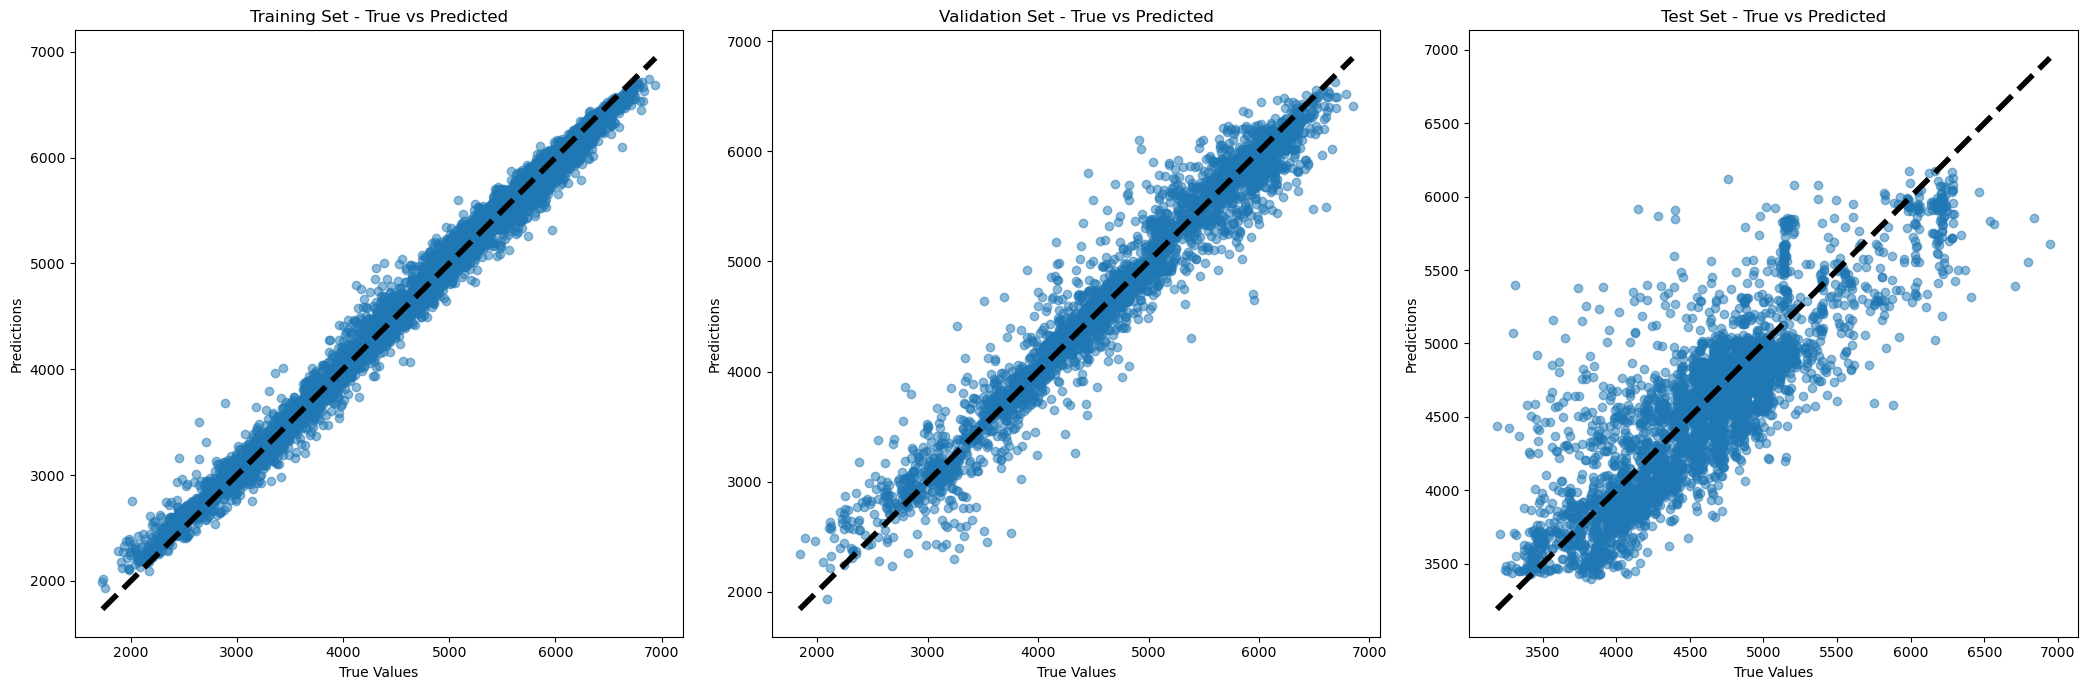

In [28]:
plt.figure(figsize=(21, 7))

# Plot for the training set
ax1 = plt.subplot(1, 3, 1)
plot_true_vs_predicted(ax1, y_train, y_train_pred, 'Training Set - True vs Predicted')

# Plot for the validation set
ax2 = plt.subplot(1, 3, 2)
plot_true_vs_predicted(ax2, y_val, y_val_pred, 'Validation Set - True vs Predicted')

# Plot for the test set
ax3 = plt.subplot(1, 3, 3)
plot_true_vs_predicted(ax3, y_test, y_test_pred_vp, 'Test Set - True vs Predicted')

plt.tight_layout()
plt.show()

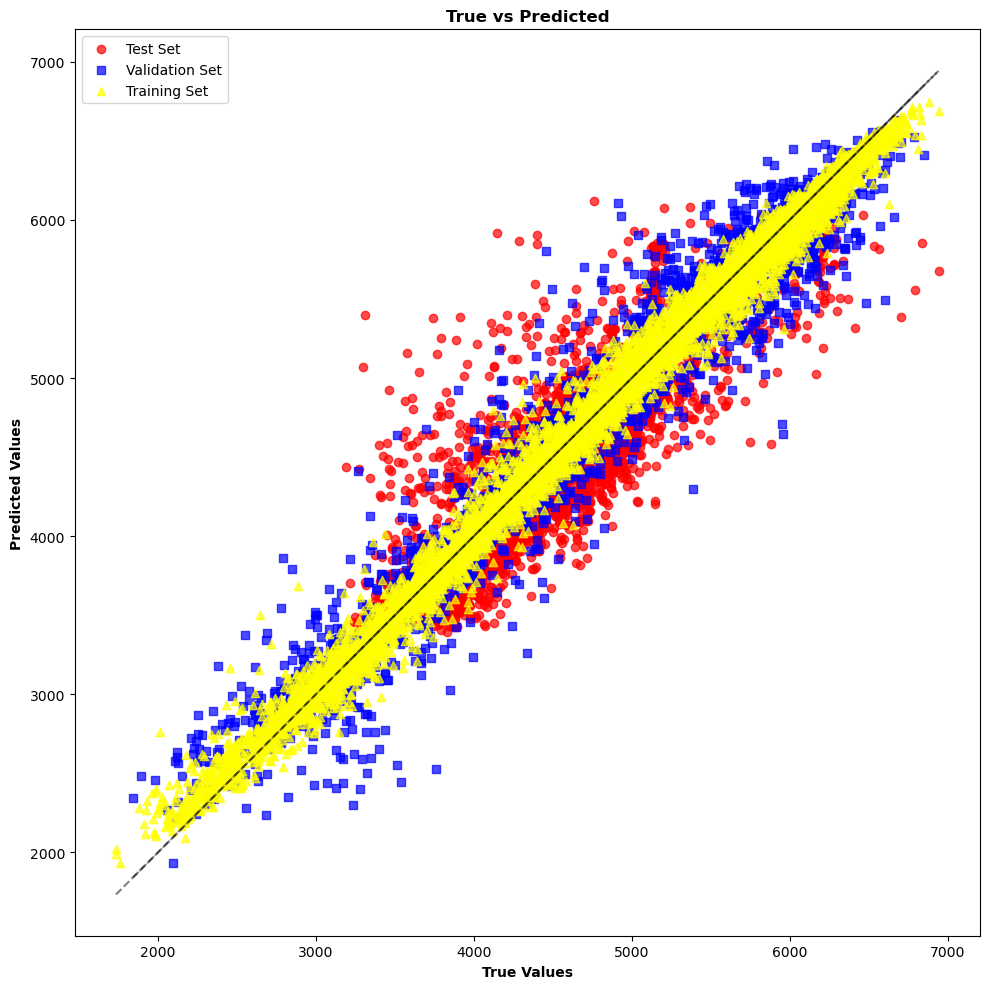

In [29]:
plt.figure(figsize=(10, 10))
ax = plt.subplot(1, 1, 1)

plot_true_vs_predicted_v1(ax, y_test, y_test_pred_vp, 'Test Set', 'o', 'red')
plot_true_vs_predicted_v1(ax, y_val, y_val_pred, 'Validation Set', 's', 'blue')
plot_true_vs_predicted_v1(ax, y_train, y_train_pred, 'Training Set', '^', 'yellow')

plt.tight_layout()
plt.show()

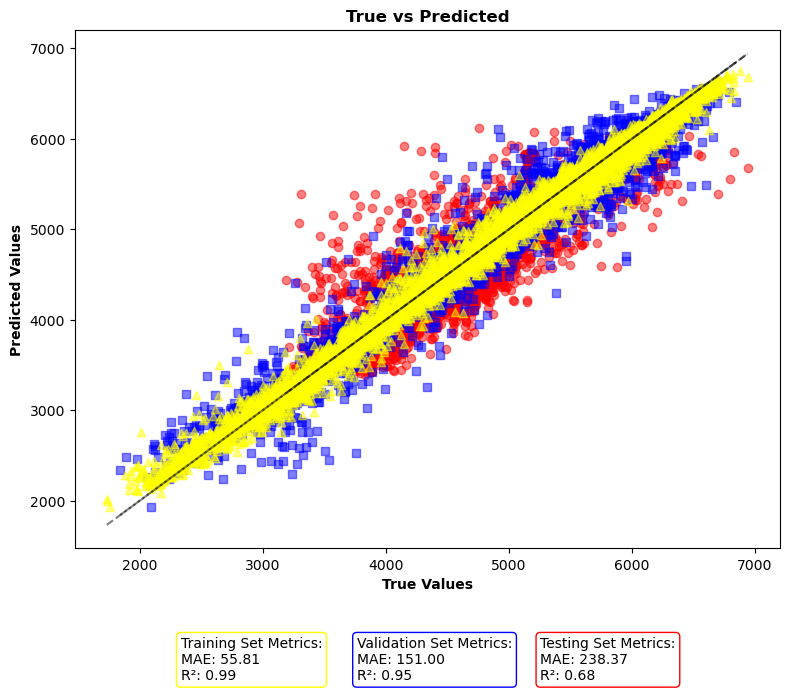

In [30]:
plt.figure(figsize=(8, 8))
ax = plt.subplot(1, 1, 1)

plot_true_vs_predicted_v2(ax, y_test, y_test_pred_vp, 'Testing Set', 'o', 'red', 0.66, -0.17)
plot_true_vs_predicted_v2(ax, y_val, y_val_pred, 'Validation Set', 's', 'blue', 0.4, -0.17)
plot_true_vs_predicted_v2(ax, y_train, y_train_pred, 'Training Set', '^', 'yellow', 0.15, -0.17)

plt.tight_layout(rect=[0, 0.1, 1, 1])
plt.show()

In [32]:
def calculate_vpvrh(df):
    # (1 GPa = 1e9 Pa)
    KVRH = df['K_VRH'] * 1e9
    GVRH = df['G_VRH'] * 1e9
    
    # (1 g/cm^3 = 1000 kg/m^3)
    rho = df['RHOZ'] * 1000
    
    df['VRH_VP'] = np.sqrt((KVRH + 4.0/3.0 * GVRH) / rho)
    return df

train_df_vp = calculate_vpvrh(train_df_vp)

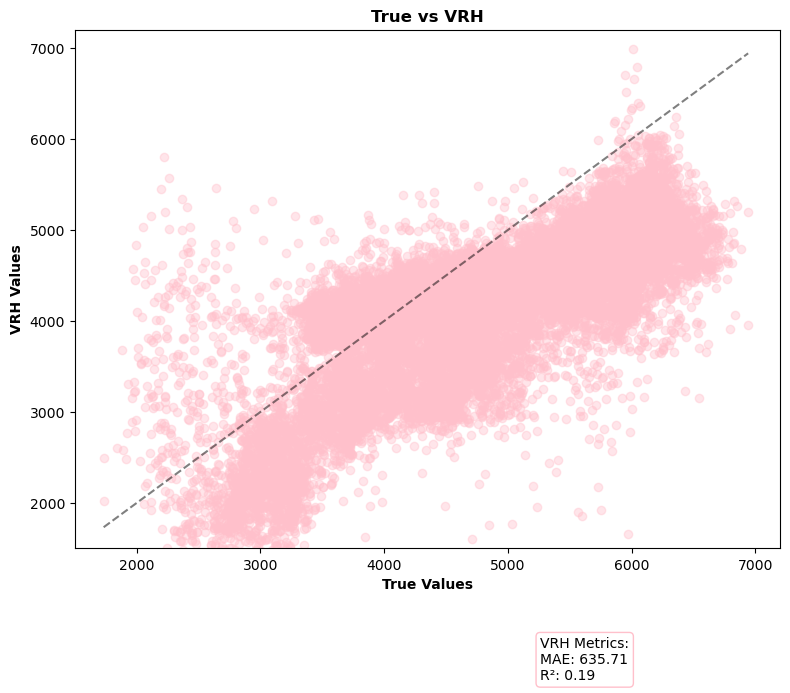

In [33]:
def plot_true_vs_vrh(ax, true_data, predicted_data, label, marker, color, x_pos, y_pos):
    mae = mean_absolute_error(true_data, predicted_data)
    r2 = r2_score(true_data, predicted_data)
    ax.scatter(true_data, predicted_data, alpha=0.4, label=f'{label}', color=color, marker=marker)
    ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', alpha=0.5)
    ax.set_xlabel('True Values', fontweight='bold')
    ax.set_ylabel('VRH Values', fontweight='bold')
    ax.set_title('True vs VRH', fontweight='bold')
    plt.xlim(1500, 7200)
    plt.ylim(1500, 7200)
    # Set text for metrics below the plot area
    ax.text(x_pos, y_pos, f'{label} Metrics:\nMAE: {mae:.2f}\nR²: {r2:.2f}', transform=ax.transAxes, verticalalignment='top', horizontalalignment='left', fontsize=10, bbox=dict(boxstyle="round,pad=0.3", edgecolor=color, facecolor='white'))

plt.figure(figsize=(8, 8))
ax = plt.subplot(1, 1, 1)

plot_true_vs_vrh(ax, df['VP'], df['VRH_VP'], 'VRH', 'o', 'pink', 0.66, -0.17)

plt.tight_layout(rect=[0, 0.1, 1, 1])
plt.show()

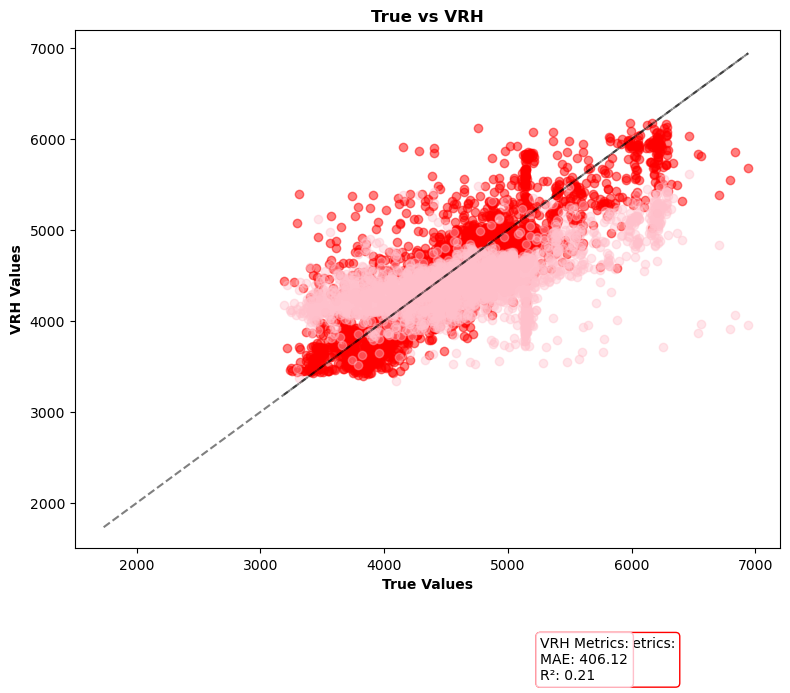

In [34]:
plt.figure(figsize=(8, 8))
ax = plt.subplot(1, 1, 1)

plot_true_vs_predicted_v2(ax, y_test, y_test_pred_vp, 'Testing Set', 'o', 'red', 0.66, -0.17)
plot_true_vs_vrh(ax, y_test, test_df_vp['VRH_VP'], 'VRH', 'o', 'pink', 0.66, -0.17)

plt.tight_layout(rect=[0, 0.1, 1, 1])
plt.show()

### 3. Plotting Results

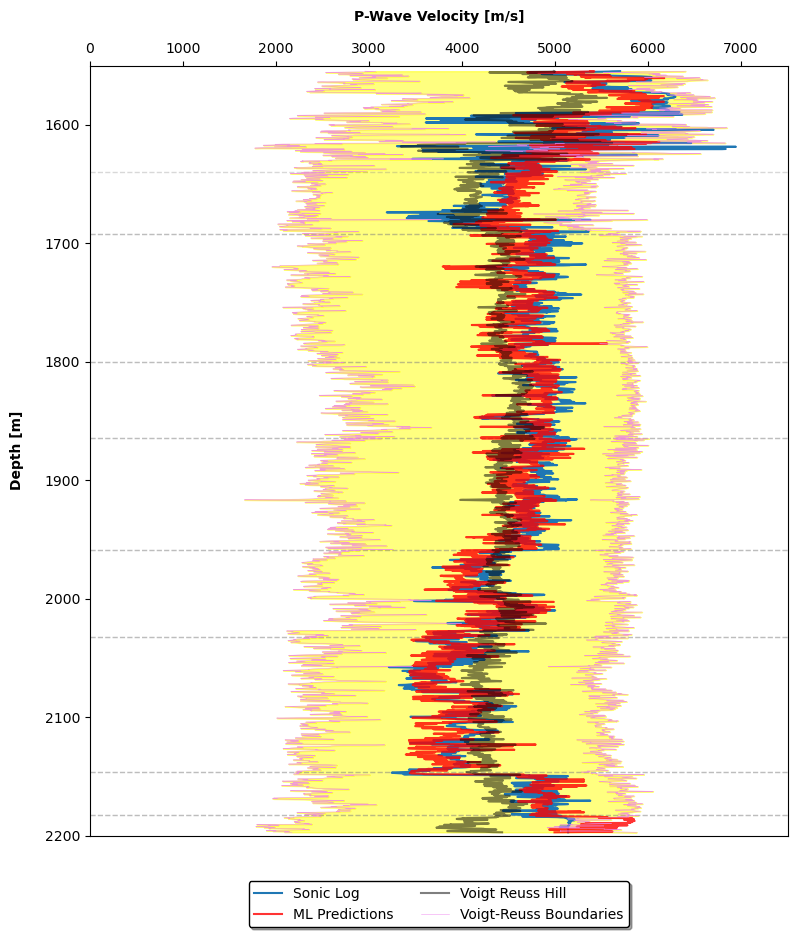

In [36]:
plot_results('P-Wave Velocity [m/s]', test_df_vp, y_test_pred_vp, y_test, 'VOIGT_VP', 'REUSS_VP','VRH_VP', 0, 7500, 2200, 1550)

## TRAINING FOR VS

Epoch 1, MAE: 2342.6447, R-squared: -14.0845
Epoch 10, MAE: 235.2005, R-squared: 0.7859
Epoch 20, MAE: 201.5935, R-squared: 0.8330
Epoch 30, MAE: 192.9904, R-squared: 0.8462
Epoch 40, MAE: 184.9885, R-squared: 0.8588
Epoch 50, MAE: 176.4616, R-squared: 0.8697
Epoch 60, MAE: 168.9836, R-squared: 0.8768
Epoch 70, MAE: 163.5977, R-squared: 0.8822
Epoch 80, MAE: 160.2951, R-squared: 0.8862
Epoch 90, MAE: 158.1909, R-squared: 0.8899
Epoch 100, MAE: 155.6002, R-squared: 0.8921
Epoch 110, MAE: 154.3454, R-squared: 0.8939
Epoch 120, MAE: 153.3159, R-squared: 0.8948
Epoch 130, MAE: 151.7210, R-squared: 0.8977
Epoch 140, MAE: 150.1493, R-squared: 0.8990
Epoch 150, MAE: 148.2051, R-squared: 0.9014
Epoch 160, MAE: 147.1862, R-squared: 0.9024
Epoch 170, MAE: 145.9234, R-squared: 0.9042
Epoch 180, MAE: 144.7830, R-squared: 0.9059
Epoch 190, MAE: 143.6709, R-squared: 0.9074
Epoch 200, MAE: 142.9664, R-squared: 0.9074
Epoch 210, MAE: 141.9362, R-squared: 0.9085
Epoch 220, MAE: 141.1414, R-squared: 0.9

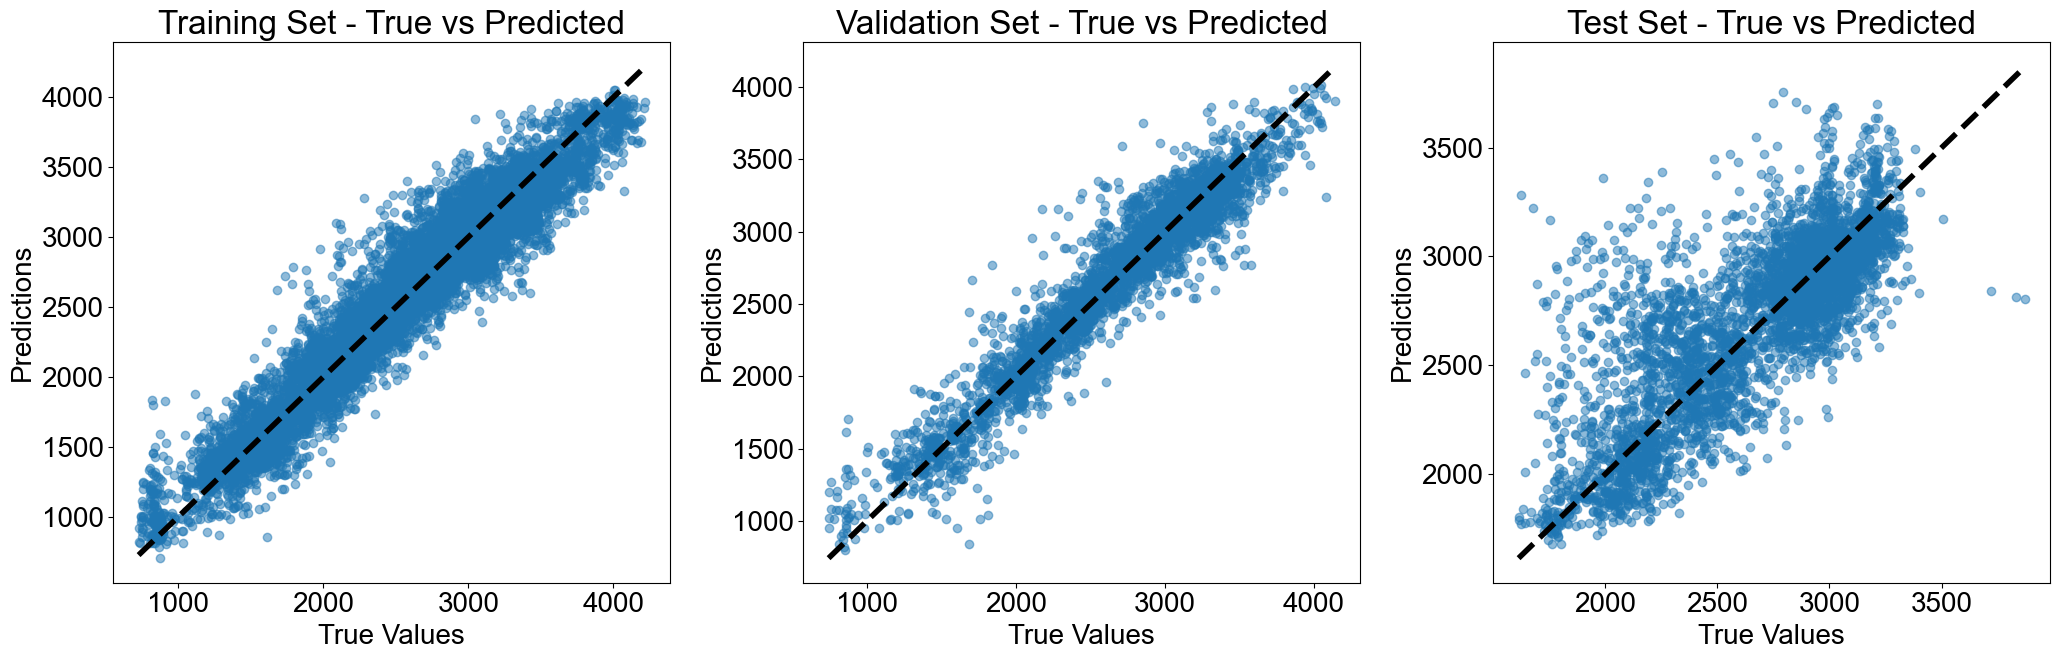

In [37]:
# TRAINING FOR VS

target_column = 'VS'
predictor_cols = ['BOUND_WATER','CALCITE','CHLORITE','DOLOMITE',#'HEMATITE',
                    'ILLITE','K-FELDSPAR','KAOLINITE','QUARTZ','UWATER']

X = train_df_vs[predictor_cols]
y = train_df_vs[target_column]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Defining the Neural Network with added complexity
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(len(predictor_cols), 256)  
        self.fc2 = nn.Linear(256, 64) 
        self.fc4 = nn.Linear(64, 1)  
        self.relu = nn.ReLU()  # Activation function

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc4(x)
        return x

model = Net()

# Assume X_train_scaled, y_train, X_val_scaled, y_val are defined elsewhere
# Prepare Data for PyTorch
X_train_tensor = torch.tensor(X_train_scaled.astype(np.float32))
y_train_tensor = torch.tensor(y_train.values.astype(np.float32))
X_val_tensor = torch.tensor(X_val_scaled.astype(np.float32))
y_val_tensor = torch.tensor(y_val.values.astype(np.float32))

train_dataset = TensorDataset(X_train_tensor, y_train_tensor.view(-1, 1))
val_dataset = TensorDataset(X_val_tensor, y_val_tensor.view(-1, 1))

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Criterion for loss (still needed for the gradient computation)
criterion = nn.MSELoss()  
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  

num_epochs = 500

model.train()

for epoch in range(num_epochs):
    total_mae = 0
    total_r2 = 0
    count = 0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        # Computing MAE and R-squared for the current batch
        mae = mean_absolute_error(targets.detach().numpy(), outputs.detach().numpy())
        r2 = r2_score(targets.detach().numpy(), outputs.detach().numpy())
        total_mae += mae
        total_r2 += r2
        count += 1
    
    # Computing the average MAE and R-squared over all batches
    avg_mae = total_mae / count
    avg_r2 = total_r2 / count
    if((epoch+1)%10==0 or epoch==0):
        print(f'Epoch {epoch+1}, MAE: {avg_mae:.4f}, R-squared: {avg_r2:.4f}')

# TEST SET PREDICTIONS
X_test = test_df_vs.drop(['VS', 'RHOZ', 'VOIGT_VS', 'REUSS_VS', 'VRH_VS', 'DEPT', 
                          'Voigt_Shear', 'Voigt_Bulk', 'Reuss_Shear', 'Reuss_Bulk', 
                          'K_VRH', 'G_VRH'], axis=1)
y_test = test_df_vs['VS']
X_test_scaled = scaler.transform(X_test)

# Making Predictions
X_test_tensor = torch.tensor(X_test_scaled.astype(np.float32))
model.eval()
with torch.no_grad():
    test_predictions = model(X_test_tensor)
    test_predictions_np = test_predictions.numpy().flatten()
    print("Predictions:", test_predictions_np)
    
model.eval()
with torch.no_grad():
    train_predictions = model(X_train_tensor)
    train_predictions_np = train_predictions.numpy().flatten()
    print("Predictions:", train_predictions_np)
    
model.eval()
with torch.no_grad():
    val_predictions = model(X_val_tensor)
    val_predictions_np = val_predictions.numpy().flatten()
    print("Predictions:", val_predictions_np)

plt.figure(figsize=(21, 7))

# Plot for the training set
ax1 = plt.subplot(1, 3, 1)
plot_true_vs_predicted(ax1, y_train, train_predictions_np, 'Training Set - True vs Predicted')

# Plot for the validation set
ax2 = plt.subplot(1, 3, 2)
plot_true_vs_predicted(ax2, y_val, val_predictions_np, 'Validation Set - True vs Predicted')

# Plot for the test set
ax3 = plt.subplot(1, 3, 3)
plot_true_vs_predicted(ax3, y_test, test_predictions_np, 'Test Set - True vs Predicted')

plt.tight_layout()
plt.show()

# Calculate error metrics for the training set
train_rmse = mean_squared_error(y_train, train_predictions_np, squared=False)
train_mae = mean_absolute_error(y_train, train_predictions_np)
train_r2 = r2_score(y_train, train_predictions_np)

# Calculate error metrics for the validation set
val_rmse = mean_squared_error(y_val, val_predictions_np, squared=False)
val_mae = mean_absolute_error(y_val, val_predictions_np)
val_r2 = r2_score(y_val, val_predictions_np)

# Calculate error metrics for the Test set
test_rmse = mean_squared_error(y_test, test_predictions_np, squared=False)
test_mae = mean_absolute_error(y_test, test_predictions_np)
test_r2 = r2_score(y_test, test_predictions_np)

# Calculate metrics for the VRH values
vrh_rmse = mean_squared_error(y_test, list(test_df_vs['VRH_VS']), squared=False)
vrh_mae = mean_absolute_error(y_test, list(test_df_vs['VRH_VS']))
vrh_r2 = r2_score(y_test, list(test_df_vs['VRH_VS']))

# Neural Network

## TRAINING FOR VP

### 1. Building and Training the model

In [38]:
target_column = 'VP'
predictor_cols = ['BOUND_WATER','CALCITE','CHLORITE','DOLOMITE',#'HEMATITE',
                    'ILLITE','K-FELDSPAR','KAOLINITE','QUARTZ','UWATER']

X = train_df_vp[predictor_cols]
y = train_df_vp[target_column]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [39]:
# Defining the Neural Network with added complexity
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(len(predictor_cols), 256)  
        self.fc2 = nn.Linear(256, 64) 
        self.fc4 = nn.Linear(64, 1)  
        self.relu = nn.ReLU()  # Activation function

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc4(x)
        return x

model = Net()

# Assume X_train_scaled, y_train, X_val_scaled, y_val are defined elsewhere
# Prepare Data for PyTorch
X_train_tensor = torch.tensor(X_train_scaled.astype(np.float32))
y_train_tensor = torch.tensor(y_train.values.astype(np.float32))
X_val_tensor = torch.tensor(X_val_scaled.astype(np.float32))
y_val_tensor = torch.tensor(y_val.values.astype(np.float32))

train_dataset = TensorDataset(X_train_tensor, y_train_tensor.view(-1, 1))
val_dataset = TensorDataset(X_val_tensor, y_val_tensor.view(-1, 1))

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Criterion for loss (still needed for the gradient computation)
criterion = nn.MSELoss()  
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  

num_epochs = 100
model.train()

for epoch in range(num_epochs):
    total_mae = 0
    total_r2 = 0
    count = 0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        # Computing MAE and R-squared for the current batch
        mae = mean_absolute_error(targets.detach().numpy(), outputs.detach().numpy())
        r2 = r2_score(targets.detach().numpy(), outputs.detach().numpy())
        total_mae += mae
        total_r2 += r2
        count += 1
    
    # Computing the average MAE and R-squared over all batches
    avg_mae = total_mae / count
    avg_r2 = total_r2 / count
    if((epoch+1)%10==0 or epoch==0):
        print(f'Epoch {epoch+1}, MAE: {avg_mae:.4f}, R-squared: {avg_r2:.4f}')

Epoch 1, MAE: 4439.9810, R-squared: -20.5101
Epoch 10, MAE: 396.6693, R-squared: 0.7399
Epoch 20, MAE: 279.4109, R-squared: 0.8607
Epoch 30, MAE: 265.4155, R-squared: 0.8725
Epoch 40, MAE: 256.6459, R-squared: 0.8795
Epoch 50, MAE: 251.1768, R-squared: 0.8839
Epoch 60, MAE: 246.2001, R-squared: 0.8881
Epoch 70, MAE: 241.1574, R-squared: 0.8910
Epoch 80, MAE: 235.7121, R-squared: 0.8950
Epoch 90, MAE: 229.4888, R-squared: 0.8996
Epoch 100, MAE: 223.4394, R-squared: 0.9026


In [40]:
# TEST SET PREDICTIONS
X_test = test_df_vp.drop(['VP', 'RHOZ', 'VOIGT_VP', 'REUSS_VP', 'VRH_VP', 'DEPT', 
                          'Voigt_Shear', 'Voigt_Bulk', 'Reuss_Shear', 'Reuss_Bulk', 
                          'K_VRH', 'G_VRH'], axis=1)
y_test = test_df_vp['VP']
X_test_scaled = scaler.transform(X_test)

In [41]:
# Making Predictions
X_test_tensor = torch.tensor(X_test_scaled.astype(np.float32))
model.eval()
with torch.no_grad():
    test_predictions = model(X_test_tensor)
    test_predictions_np = test_predictions.numpy().flatten()
    print("Predictions:", test_predictions_np)
    
model.eval()
with torch.no_grad():
    train_predictions = model(X_train_tensor)
    train_predictions_np = train_predictions.numpy().flatten()
    print("Predictions:", train_predictions_np)
    
model.eval()
with torch.no_grad():
    val_predictions = model(X_val_tensor)
    val_predictions_np = val_predictions.numpy().flatten()
    print("Predictions:", val_predictions_np)

Predictions: [5529.462  5510.201  5547.609  ... 5382.0146 5531.265  5759.1567]
Predictions: [4716.066  3505.6443 3569.5408 ... 4606.7217 6072.564  5562.834 ]
Predictions: [2416.553  5868.15   4432.1143 ... 5641.8096 4590.112  4374.6177]


### 2. Plotting predictions with True Values

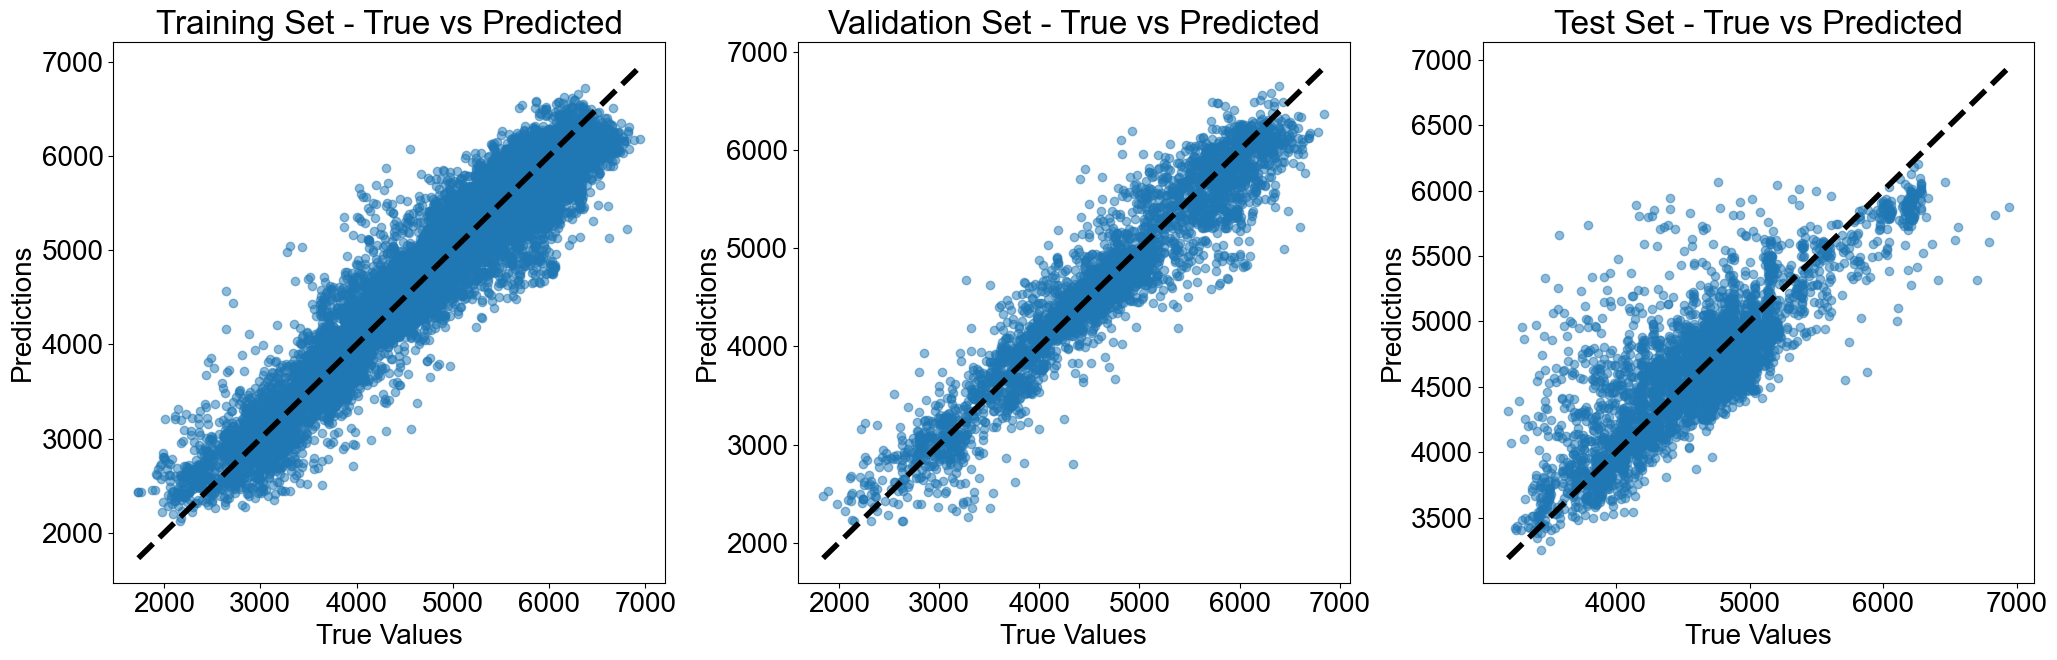

In [42]:
plt.figure(figsize=(21, 7))

# Plot for the training set
ax1 = plt.subplot(1, 3, 1)
plot_true_vs_predicted(ax1, y_train, train_predictions_np, 'Training Set - True vs Predicted')

# Plot for the validation set
ax2 = plt.subplot(1, 3, 2)
plot_true_vs_predicted(ax2, y_val, val_predictions_np, 'Validation Set - True vs Predicted')

# Plot for the test set
ax3 = plt.subplot(1, 3, 3)
plot_true_vs_predicted(ax3, y_test, test_predictions_np, 'Test Set - True vs Predicted')

plt.tight_layout()
plt.show()

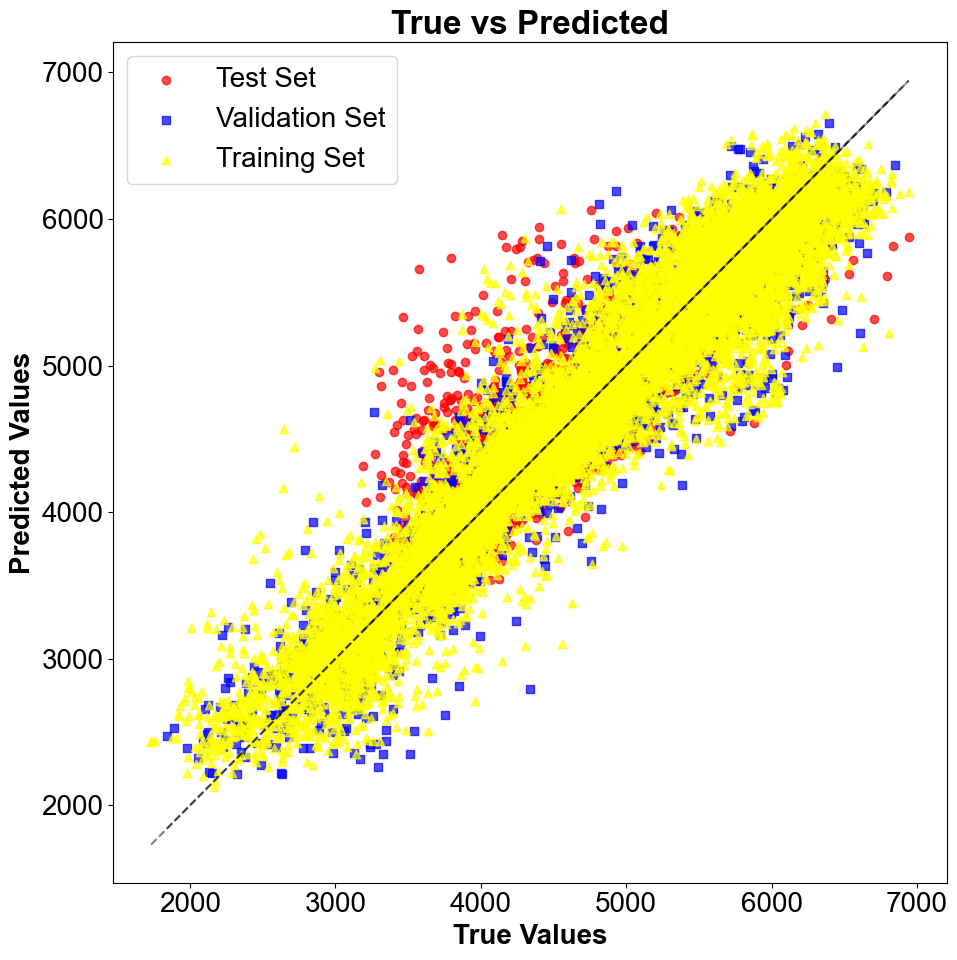

In [43]:
def plot_true_vs_predicted_v1(ax, true_data, predicted_data, label, marker, color):
    ax.scatter(true_data, predicted_data, alpha=0.7, label=label, marker=marker, color=color)
    ax.plot([true_data.min(), true_data.max()], [true_data.min(), true_data.max()], 'k--', alpha=0.5)
    ax.set_xlabel('True Values', fontweight='bold')
    ax.set_ylabel('Predicted Values', fontweight='bold')
    ax.set_title('True vs Predicted', fontweight='bold')
    ax.legend()

plt.figure(figsize=(10, 10))
ax = plt.subplot(1, 1, 1)

plot_true_vs_predicted_v1(ax, y_test, test_predictions_np, 'Test Set', 'o', 'red')
plot_true_vs_predicted_v1(ax, y_val, val_predictions_np, 'Validation Set', 's', 'blue')
plot_true_vs_predicted_v1(ax, y_train, train_predictions_np, 'Training Set', '^', 'yellow')

plt.tight_layout()
plt.show()

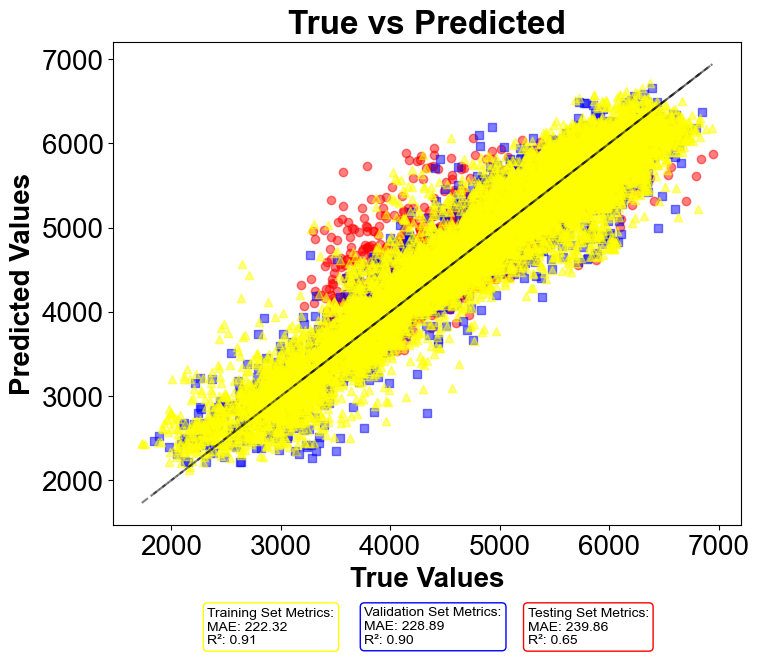

In [44]:
def plot_true_vs_predicted_v2(ax, true_data, predicted_data, label, marker, color, x_pos, y_pos):
    mae = mean_absolute_error(true_data, predicted_data)
    r2 = r2_score(true_data, predicted_data)
    ax.scatter(true_data, predicted_data, alpha=0.5, label=f'{label}', color=color, marker=marker)
    ax.plot([true_data.min(), true_data.max()], [true_data.min(), true_data.max()], 'k--', alpha=0.5)
    ax.set_xlabel('True Values', fontweight='bold')
    ax.set_ylabel('Predicted Values', fontweight='bold')
    ax.set_title('True vs Predicted', fontweight='bold')
    # Set text for metrics below the plot area
    ax.text(x_pos, y_pos, f'{label} Metrics:\nMAE: {mae:.2f}\nR²: {r2:.2f}', transform=ax.transAxes, verticalalignment='top', horizontalalignment='left', fontsize=10, bbox=dict(boxstyle="round,pad=0.3", edgecolor=color, facecolor='white'))

plt.figure(figsize=(8, 8))
ax = plt.subplot(1, 1, 1)

# Adjust x_pos and y_pos for each dataset to display metrics in one horizontal line below the graph
plot_true_vs_predicted_v2(ax, y_test, test_predictions_np, 'Testing Set', 'o', 'red', 0.66, -0.17)
plot_true_vs_predicted_v2(ax, y_val, val_predictions_np, 'Validation Set', 's', 'blue', 0.4, -0.17)
plot_true_vs_predicted_v2(ax, y_train, train_predictions_np, 'Training Set', '^', 'yellow', 0.15, -0.17)

plt.tight_layout(rect=[0, 0.1, 1, 1])
plt.show()

### 3. Comparing Metrics

In [45]:
# Calculate error metrics for the training set
train_rmse = mean_squared_error(y_train, train_predictions_np, squared=False)
train_mae = mean_absolute_error(y_train, train_predictions_np)
train_r2 = r2_score(y_train, train_predictions_np)

# Calculate error metrics for the validation set
val_rmse = mean_squared_error(y_val, val_predictions_np, squared=False)
val_mae = mean_absolute_error(y_val, val_predictions_np)
val_r2 = r2_score(y_val, val_predictions_np)

# Calculate error metrics for the Test set
test_rmse = mean_squared_error(y_test, test_predictions_np, squared=False)
test_mae = mean_absolute_error(y_test, test_predictions_np)
test_r2 = r2_score(y_test, test_predictions_np)

# Calculate metrics for the VRH values
vrh_rmse = mean_squared_error(y_test, list(test_df_vp['VRH_VP']), squared=False)
vrh_mae = mean_absolute_error(y_test, list(test_df_vp['VRH_VP']))
vrh_r2 = r2_score(y_test, list(test_df_vp['VRH_VP']))

In [46]:
fig = create_metrics_table_plotly(train_rmse, train_mae, train_r2, val_rmse, val_mae, val_r2, test_rmse, test_mae, test_r2, vrh_rmse, vrh_mae, vrh_r2)
fig.show()

### 4. Plotting Results

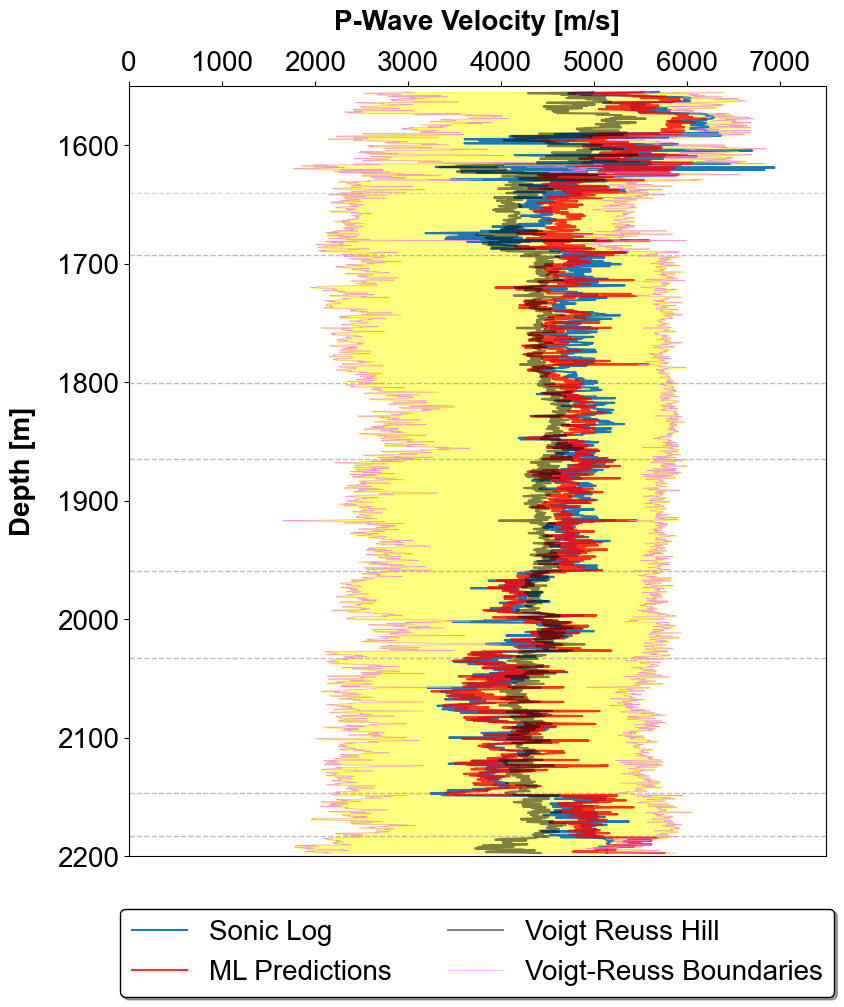

In [47]:
plot_results('P-Wave Velocity [m/s]', test_df_vp, test_predictions_np, y_test, 'VOIGT_VP', 'REUSS_VP','VRH_VP', 0, 7500, 2200, 1550)

## TRAINING FOR VS

In [48]:
target_column = 'VS'
predictor_cols = ['BOUND_WATER','CALCITE','CHLORITE','DOLOMITE',#'HEMATITE',
                    'ILLITE','K-FELDSPAR','KAOLINITE','QUARTZ','UWATER']

X = train_df_vs[predictor_cols]
y = train_df_vs[target_column]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [49]:
# Defining the Neural Network with added complexity
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(len(predictor_cols), 256)  
        self.fc2 = nn.Linear(256, 64) 
        self.fc4 = nn.Linear(64, 1)  
        self.relu = nn.ReLU()  # Activation function

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc4(x)
        return x

model = Net()

# Assume X_train_scaled, y_train, X_val_scaled, y_val are defined elsewhere
# Prepare Data for PyTorch
X_train_tensor = torch.tensor(X_train_scaled.astype(np.float32))
y_train_tensor = torch.tensor(y_train.values.astype(np.float32))
X_val_tensor = torch.tensor(X_val_scaled.astype(np.float32))
y_val_tensor = torch.tensor(y_val.values.astype(np.float32))

train_dataset = TensorDataset(X_train_tensor, y_train_tensor.view(-1, 1))
val_dataset = TensorDataset(X_val_tensor, y_val_tensor.view(-1, 1))

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Criterion for loss (still needed for the gradient computation)
criterion = nn.MSELoss()  
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  

num_epochs = 500

model.train()

for epoch in range(num_epochs):
    total_mae = 0
    total_r2 = 0
    count = 0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        # Computing MAE and R-squared for the current batch
        mae = mean_absolute_error(targets.detach().numpy(), outputs.detach().numpy())
        r2 = r2_score(targets.detach().numpy(), outputs.detach().numpy())
        total_mae += mae
        total_r2 += r2
        count += 1
    
    # Computing the average MAE and R-squared over all batches
    avg_mae = total_mae / count
    avg_r2 = total_r2 / count
    if((epoch+1)%10==0 or epoch==0):
        print(f'Epoch {epoch+1}, MAE: {avg_mae:.4f}, R-squared: {avg_r2:.4f}')

Epoch 1, MAE: 2430.3031, R-squared: -14.7174
Epoch 10, MAE: 245.5030, R-squared: 0.7664
Epoch 20, MAE: 202.2011, R-squared: 0.8337
Epoch 30, MAE: 191.6725, R-squared: 0.8481
Epoch 40, MAE: 183.9661, R-squared: 0.8592
Epoch 50, MAE: 176.2342, R-squared: 0.8695
Epoch 60, MAE: 167.4563, R-squared: 0.8783
Epoch 70, MAE: 160.9085, R-squared: 0.8859
Epoch 80, MAE: 156.4228, R-squared: 0.8911
Epoch 90, MAE: 154.1686, R-squared: 0.8929
Epoch 100, MAE: 152.3905, R-squared: 0.8953
Epoch 110, MAE: 150.6901, R-squared: 0.8976
Epoch 120, MAE: 149.0692, R-squared: 0.8998
Epoch 130, MAE: 147.2571, R-squared: 0.9027
Epoch 140, MAE: 145.6096, R-squared: 0.9040
Epoch 150, MAE: 144.1758, R-squared: 0.9065
Epoch 160, MAE: 142.9154, R-squared: 0.9078
Epoch 170, MAE: 141.6332, R-squared: 0.9097
Epoch 180, MAE: 140.8821, R-squared: 0.9111
Epoch 190, MAE: 139.4698, R-squared: 0.9118
Epoch 200, MAE: 138.7588, R-squared: 0.9136
Epoch 210, MAE: 137.9287, R-squared: 0.9143
Epoch 220, MAE: 136.6917, R-squared: 0.9

In [50]:
# TEST SET PREDICTIONS
X_test = test_df_vs.drop(['VS', 'RHOZ', 'VOIGT_VS', 'REUSS_VS', 'VRH_VS', 'DEPT', 
                          'Voigt_Shear', 'Voigt_Bulk', 'Reuss_Shear', 'Reuss_Bulk', 
                          'K_VRH', 'G_VRH'], axis=1)
y_test = test_df_vs['VS']
X_test_scaled = scaler.transform(X_test)

In [51]:
# Making Predictions
X_test_tensor = torch.tensor(X_test_scaled.astype(np.float32))
model.eval()
with torch.no_grad():
    test_predictions = model(X_test_tensor)
    test_predictions_np = test_predictions.numpy().flatten()
    print("Predictions:", test_predictions_np)
    
model.eval()
with torch.no_grad():
    train_predictions = model(X_train_tensor)
    train_predictions_np = train_predictions.numpy().flatten()
    print("Predictions:", train_predictions_np)
    
model.eval()
with torch.no_grad():
    val_predictions = model(X_val_tensor)
    val_predictions_np = val_predictions.numpy().flatten()
    print("Predictions:", val_predictions_np)

Predictions: [2784.1365 2797.4592 2843.4143 ... 3365.9011 3535.6924 3512.5735]
Predictions: [3030.6504 1903.1833 1777.9939 ... 2872.692  3290.3147 3210.6206]
Predictions: [ 835.87195 3157.0938  2641.8877  ... 2853.3713  3046.9229  2696.7688 ]


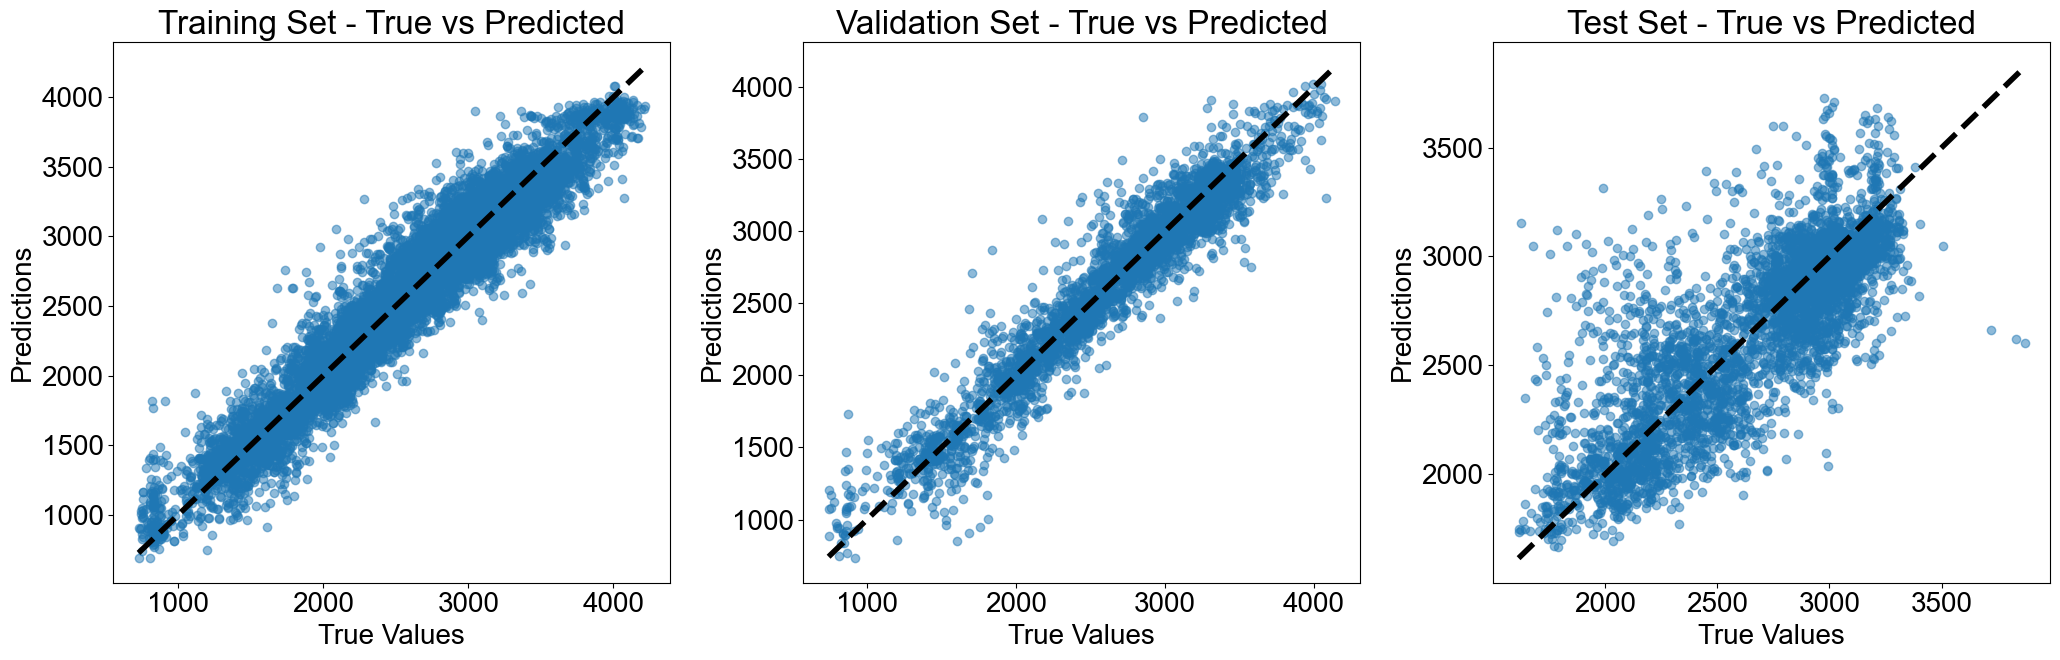

In [52]:
plt.figure(figsize=(21, 7))

ax1 = plt.subplot(1, 3, 1)
plot_true_vs_predicted(ax1, y_train, train_predictions_np, 'Training Set - True vs Predicted')

ax2 = plt.subplot(1, 3, 2)
plot_true_vs_predicted(ax2, y_val, val_predictions_np, 'Validation Set - True vs Predicted')

ax3 = plt.subplot(1, 3, 3)
plot_true_vs_predicted(ax3, y_test, test_predictions_np, 'Test Set - True vs Predicted')

plt.tight_layout()
plt.show()

In [53]:
# Calculate error metrics for the training set
train_rmse = mean_squared_error(y_train, train_predictions_np, squared=False)
train_mae = mean_absolute_error(y_train, train_predictions_np)
train_r2 = r2_score(y_train, train_predictions_np)

# Calculate error metrics for the validation set
val_rmse = mean_squared_error(y_val, val_predictions_np, squared=False)
val_mae = mean_absolute_error(y_val, val_predictions_np)
val_r2 = r2_score(y_val, val_predictions_np)

# Calculate error metrics for the Test set
test_rmse = mean_squared_error(y_test, test_predictions_np, squared=False)
test_mae = mean_absolute_error(y_test, test_predictions_np)
test_r2 = r2_score(y_test, test_predictions_np)

# Calculate metrics for the VRH values
vrh_rmse = mean_squared_error(y_test, list(test_df_vs['VRH_VS']), squared=False)
vrh_mae = mean_absolute_error(y_test, list(test_df_vs['VRH_VS']))
vrh_r2 = r2_score(y_test, list(test_df_vs['VRH_VS']))

## XGBoost

### 1. Training for Vp 

In [55]:
train_df_vp.head()

BOUND_WATER  CALCITE  CHLORITE  DOLOMITE   ILLITE  K-FELDSPAR  KAOLINITE  \
0      0.00139  0.92588       0.0       0.0  0.00081     0.04413    0.01871   
1      0.00291  0.91290       0.0       0.0  0.01286     0.04058    0.01871   
2      0.00468  0.89792       0.0       0.0  0.02690     0.03663    0.01871   
3      0.00407  0.88793       0.0       0.0  0.02208     0.03811    0.01871   
4      0.00134  0.88843       0.0       0.0  0.00042     0.04504    0.01871   

    QUARTZ   UWATER     DEPT    RHOZ  Voigt_Bulk  Reuss_Bulk  Voigt_Shear  \
0  0.00906  0.00001  4361.25  2.8598   73.130039   36.863518    30.716078   
1  0.01203  0.00001  4361.75  2.8542   72.131359   28.036393    30.395018   
2  0.01373  0.00144  4362.25  2.8324   70.923770   21.631896    29.950865   
3  0.01604  0.01306  4362.75  2.7999   70.314500   20.837212    29.748278   
4  0.01929  0.02676  4363.25  2.7698   70.724669   25.762189    29.980905   

   Reuss_Shear      K_VRH      G_VRH           VP       VRH_VP  
0     0.071195  54.996778  15.393636  6263.510060  5138.872438  
1     0.034183  50.083876  15.214601  6481.686259  4965.369890  
2     0.016323  46.277833  14.983594  6563.708892  4836.544372  
3     0.005836  45.575856  14.877057  6334.250151  4833.449955  
4     0.003558  48.243429  14.992231  6141.289554  4963.331164

In [56]:
target_column = 'VP'
predictor_cols = ['BOUND_WATER','CALCITE','CHLORITE','DOLOMITE',#'HEMATITE',
                    'ILLITE','K-FELDSPAR','KAOLINITE','QUARTZ','UWATER']

X = train_df_vp[predictor_cols]
y = train_df_vp[target_column]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [57]:
param_grid = {
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [50, 100, 200],
    'subsample': [0.7, 1],
    'colsample_bytree': [0.7, 1],
    'reg_alpha': [ 0.1]
}

xgb_model = XGBRegressor(objective='reg:squarederror')

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)
grid_search.fit(X_train_scaled, y_train)

print(f"Best parameters found: {grid_search.best_params_}")

best_model = grid_search.best_estimator_
y_val_pred = best_model.predict(X_val_scaled)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters found: {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 200, 'reg_alpha': 0.1, 'subsample': 0.7}


In [58]:
filename = 'Model weights/best_xgb_model.joblib'
joblib.dump(best_model, filename)

['Model weights/best_xgb_model.joblib']

In [59]:
filename = 'Model weights/best_xgb_model.joblib'
best_model = joblib.load(filename)

In [60]:
y_val_pred = best_model.predict(X_val_scaled)
y_train_pred = best_model.predict(X_train_scaled)

In [61]:
best_model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=9,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [62]:
# TEST SET PREDICTIONS
X_test = test_df_vp.drop(['VP', 'RHOZ', 'VOIGT_VP', 'REUSS_VP', 'VRH_VP', 'DEPT', 
                          'Voigt_Shear', 'Voigt_Bulk', 'Reuss_Shear', 'Reuss_Bulk', 
                          'K_VRH', 'G_VRH'], axis=1)
y_test = test_df_vp['VP']
X_test_scaled = scaler.transform(X_test)

In [63]:
y_test_pred_vp = best_model.predict(X_test_scaled)

In [64]:
# Calculate error metrics for the training set
train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Calculate error metrics for the validation set
val_rmse = mean_squared_error(y_val, y_val_pred, squared=False)
val_mae = mean_absolute_error(y_val, y_val_pred)
val_r2 = r2_score(y_val, y_val_pred)

# Calculate error metrics for the test set
test_rmse = mean_squared_error(y_test, y_test_pred_vp, squared=False)
test_mae = mean_absolute_error(y_test, y_test_pred_vp)
test_r2 = r2_score(y_test, y_test_pred_vp)

# Calculate metrics for the VRH values
vrh_rmse = mean_squared_error(y_test, list(test_df_vp['VRH_VP']), squared=False)
vrh_mae = mean_absolute_error(y_test, list(test_df_vp['VRH_VP']))
vrh_r2 = r2_score(y_test, list(test_df_vp['VRH_VP']))

fig = create_metrics_table_plotly(train_rmse, train_mae, train_r2, val_rmse, val_mae, val_r2, test_rmse, test_mae, test_r2, vrh_rmse, vrh_mae, vrh_r2)
fig.show()

1. **Root Mean Square Error (RMSE):** This measures the average magnitude of the errors between the predicted values from the model and the actual values. It squares the errors before averaging to give more weight to larger errors. The RMSE for the training data is quite low at around 73.73, which suggests that the model fits the training data well. However, the RMSE for the validation data is much higher at approximately 226.88, indicating that the model doesn’t perform as well on the validation set.

2. **Mean Absolute Error (MAE):** This metric calculates the average absolute difference between the predicted values and the actual values. Unlike RMSE, MAE doesn’t square the errors, so it doesn’t penalize larger errors as heavily. The MAE is lower than the RMSE in both training (approximately 54.76) and validation (approximately 154.55), which is typically the case. However, the jump in error from training to validation suggests that the model might not generalize well to unseen data.

3. **R-squared (R²):** This is a statistical measure of how close the data are to the fitted regression line. It is also known as the coefficient of determination. The R² for both training and validation is quite high (close to 1), with training at about 0.995 and validation at about 0.948. This suggests that the model explains a large proportion of the variance in the outcome variable for both training and validation datasets.

However, the significantly higher RMSE and MAE for the validation data compared to the training data indicate that the model might be overfitting to the training data. Overfitting occurs when a model learns the training data too well, including the noise and outliers, which then harms its performance on new, unseen data.

In summary, model seems to be performing well on the training data but not as well on the validation data. This discrepancy suggests that the model may not generalize well to new data, likely due to overfitting. 

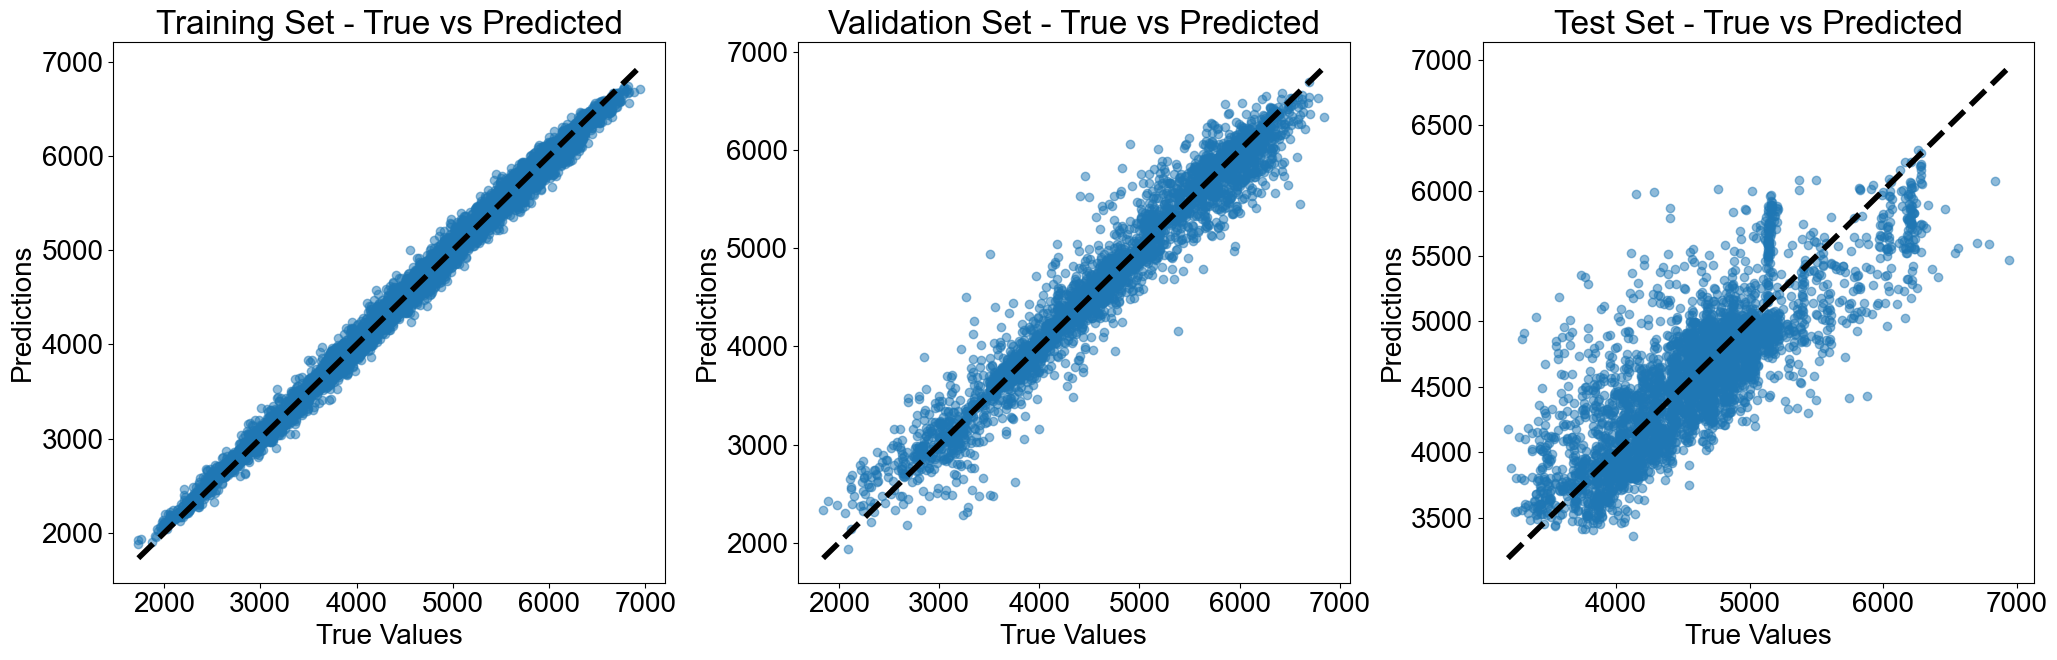

In [65]:
plt.figure(figsize=(21, 7))

# Plot for the training set
ax1 = plt.subplot(1, 3, 1)
plot_true_vs_predicted(ax1, y_train, y_train_pred, 'Training Set - True vs Predicted')

# Plot for the validation set
ax2 = plt.subplot(1, 3, 2)
plot_true_vs_predicted(ax2, y_val, y_val_pred, 'Validation Set - True vs Predicted')

# Plot for the test set
ax3 = plt.subplot(1, 3, 3)
plot_true_vs_predicted(ax3, y_test, y_test_pred_vp, 'Test Set - True vs Predicted')

plt.tight_layout()
plt.show()

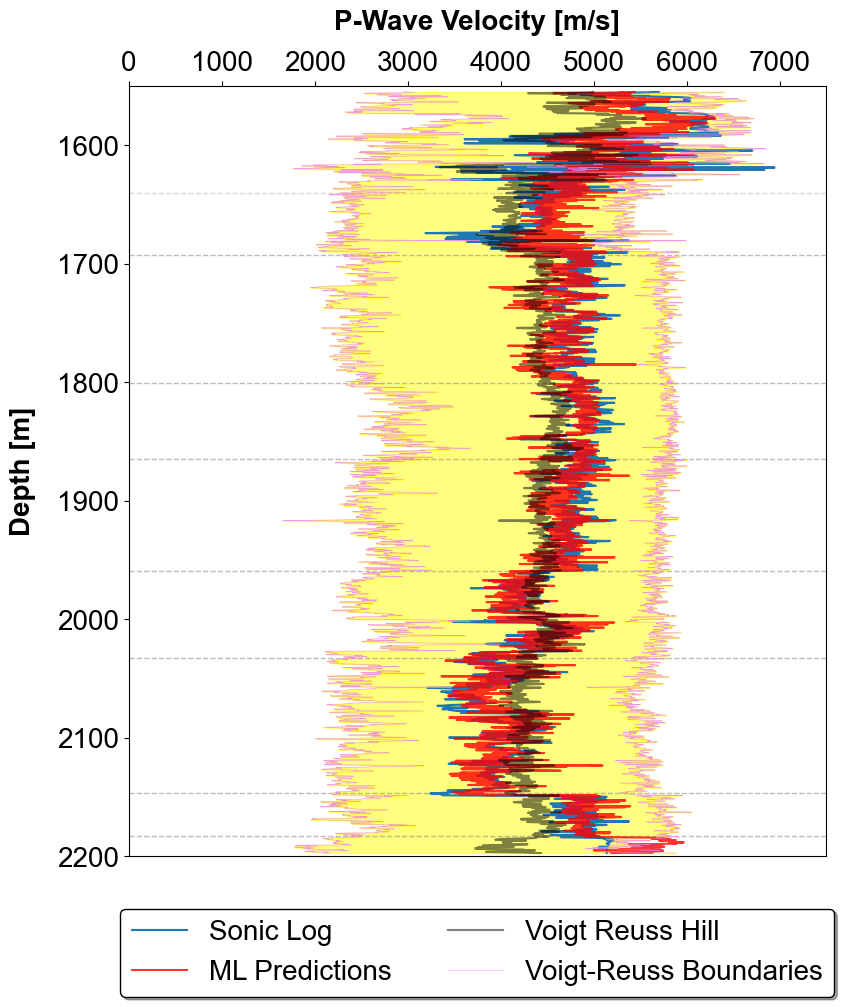

In [66]:
plot_results('P-Wave Velocity [m/s]', test_df_vp, y_test_pred_vp, y_test, 'VOIGT_VP', 'REUSS_VP','VRH_VP', 0, 7500, 2200, 1550)

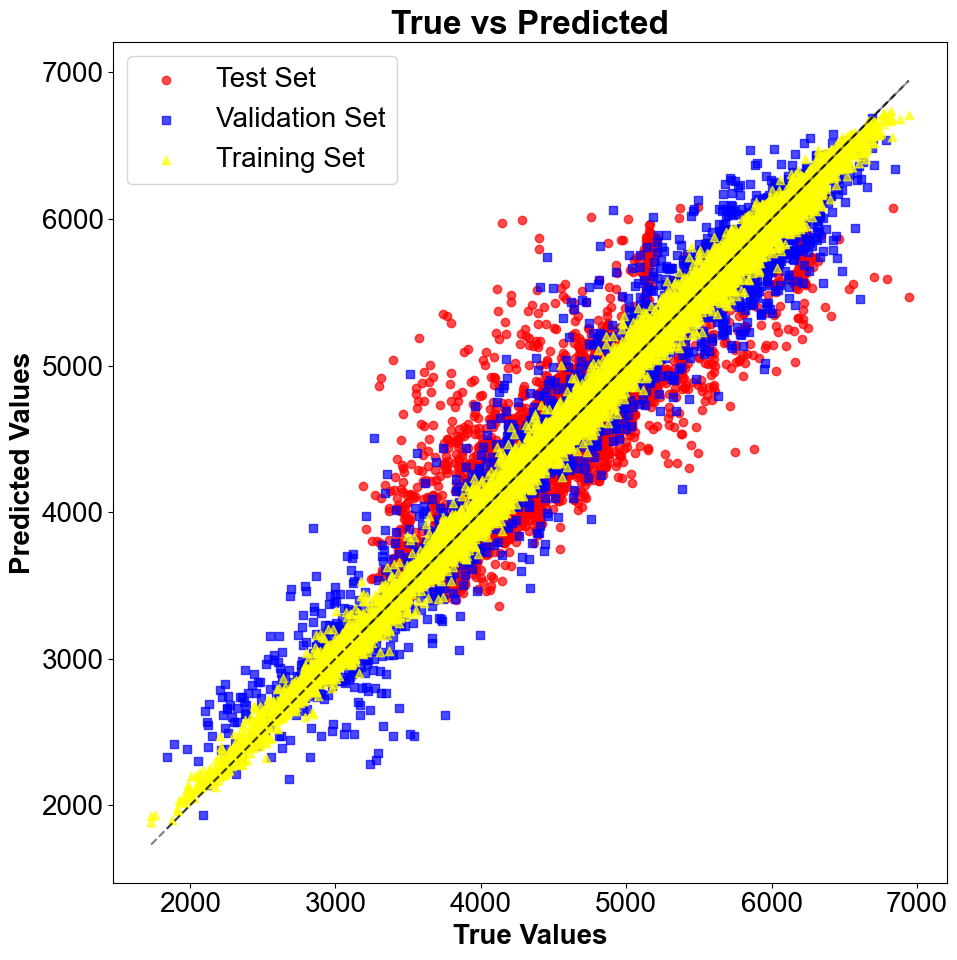

In [67]:
def plot_true_vs_predicted_v1(ax, true_data, predicted_data, label, marker, color):
    ax.scatter(true_data, predicted_data, alpha=0.7, label=label, marker=marker, color=color)
    ax.plot([true_data.min(), true_data.max()], [true_data.min(), true_data.max()], 'k--', alpha=0.5)
    ax.set_xlabel('True Values', fontweight='bold')
    ax.set_ylabel('Predicted Values', fontweight='bold')
    ax.set_title('True vs Predicted', fontweight='bold')
    ax.legend()

plt.figure(figsize=(10, 10))
ax = plt.subplot(1, 1, 1)

plot_true_vs_predicted_v1(ax, y_test, y_test_pred_vp, 'Test Set', 'o', 'red')
plot_true_vs_predicted_v1(ax, y_val, y_val_pred, 'Validation Set', 's', 'blue')
plot_true_vs_predicted_v1(ax, y_train, y_train_pred, 'Training Set', '^', 'yellow')

plt.tight_layout()
plt.show()

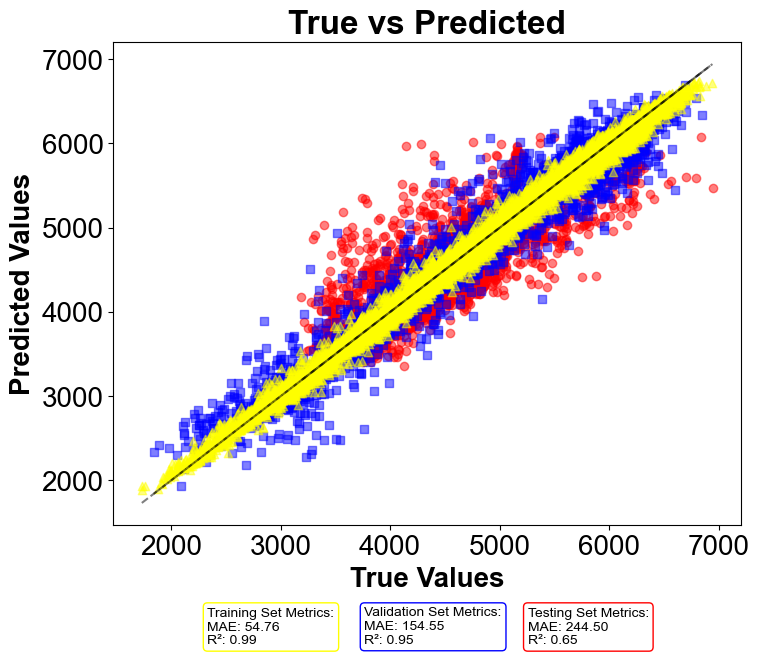

In [68]:
def plot_true_vs_predicted_v2(ax, true_data, predicted_data, label, marker, color, x_pos, y_pos):
    mae = mean_absolute_error(true_data, predicted_data)
    r2 = r2_score(true_data, predicted_data)
    ax.scatter(true_data, predicted_data, alpha=0.5, label=f'{label}', color=color, marker=marker)
    ax.plot([true_data.min(), true_data.max()], [true_data.min(), true_data.max()], 'k--', alpha=0.5)
    ax.set_xlabel('True Values', fontweight='bold')
    ax.set_ylabel('Predicted Values', fontweight='bold')
    ax.set_title('True vs Predicted', fontweight='bold')
    # Set text for metrics below the plot area
    ax.text(x_pos, y_pos, f'{label} Metrics:\nMAE: {mae:.2f}\nR²: {r2:.2f}', transform=ax.transAxes, verticalalignment='top', horizontalalignment='left', fontsize=10, bbox=dict(boxstyle="round,pad=0.3", edgecolor=color, facecolor='white'))

plt.figure(figsize=(8, 8))
ax = plt.subplot(1, 1, 1)

# Adjust x_pos and y_pos for each dataset to display metrics in one horizontal line below the graph
plot_true_vs_predicted_v2(ax, y_test, y_test_pred_vp, 'Testing Set', 'o', 'red', 0.66, -0.17)
plot_true_vs_predicted_v2(ax, y_val, y_val_pred, 'Validation Set', 's', 'blue', 0.4, -0.17)
plot_true_vs_predicted_v2(ax, y_train, y_train_pred, 'Training Set', '^', 'yellow', 0.15, -0.17)

plt.tight_layout(rect=[0, 0.1, 1, 1])
plt.show()

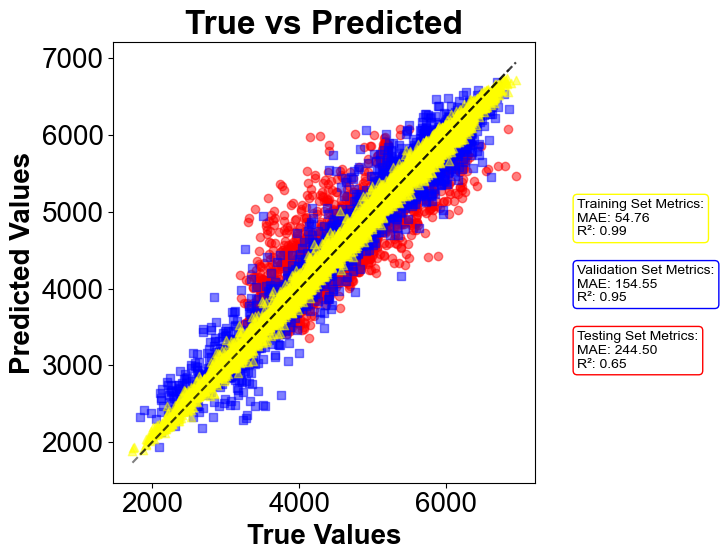

In [69]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score

def plot_true_vs_predicted_v2(ax, true_data, predicted_data, label, marker, color, x_pos, y_pos):
    mae = mean_absolute_error(true_data, predicted_data)
    r2 = r2_score(true_data, predicted_data)
    ax.scatter(true_data, predicted_data, alpha=0.5, label=f'{label}', color=color, marker=marker)
    ax.plot([true_data.min(), true_data.max()], [true_data.min(), true_data.max()], 'k--', alpha=0.5)
    ax.set_xlabel('True Values', fontweight='bold')
    ax.set_ylabel('Predicted Values', fontweight='bold')
    ax.set_title('True vs Predicted', fontweight='bold')
    # Set text for metrics on the right of the plot area
    ax.text(x_pos, y_pos, f'{label} Metrics:\nMAE: {mae:.2f}\nR²: {r2:.2f}', transform=ax.transAxes, verticalalignment='center', horizontalalignment='left', fontsize=10, bbox=dict(boxstyle="round,pad=0.3", edgecolor=color, facecolor='white'))

plt.figure(figsize=(10, 6))  # Adjust the figure size to ensure there is enough space for the text
ax = plt.subplot(1, 1, 1)

# Fixed x_pos beyond 1 for right-side display and adjusted y_pos for vertical alignment
plot_true_vs_predicted_v2(ax, y_test, y_test_pred_vp, 'Testing Set', 'o', 'red', 1.1, 0.30)
plot_true_vs_predicted_v2(ax, y_val, y_val_pred, 'Validation Set', 's', 'blue', 1.1, 0.45)
plot_true_vs_predicted_v2(ax, y_train, y_train_pred, 'Training Set', '^', 'yellow', 1.1, 0.6)

plt.tight_layout(rect=[0, 0, 0.8, 1])  # Adjust the layout to prevent clipping of text
plt.show()

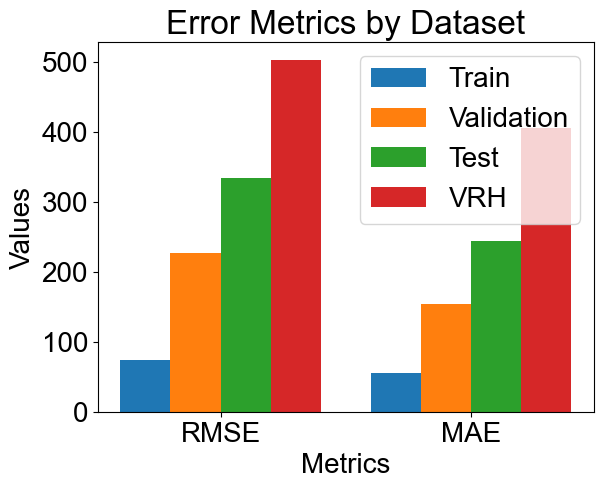

In [70]:
import matplotlib.pyplot as plt
import numpy as np

# Metrics
metrics = ['RMSE', 'MAE']
train_metrics = [train_rmse, train_mae]
val_metrics = [val_rmse, val_mae]
test_metrics = [test_rmse, test_mae]
vrh_metrics = [vrh_rmse, vrh_mae]  # Example: Replace these with actual values if they exist

n_groups = 2
index = np.arange(n_groups)
bar_width = 0.2

fig, ax = plt.subplots()

train_bar = ax.bar(index, train_metrics, bar_width, label='Train')
val_bar = ax.bar(index + bar_width, val_metrics, bar_width, label='Validation')
test_bar = ax.bar(index + 2 * bar_width, test_metrics, bar_width, label='Test')
vrh_bar = ax.bar(index + 3 * bar_width, vrh_metrics, bar_width, label='VRH')  # Adjust label as needed


ax.set_xlabel('Metrics')
ax.set_ylabel('Values')
ax.set_title('Error Metrics by Dataset')
ax.set_xticks(index + 1.5 * bar_width)
ax.set_xticklabels(metrics)
ax.legend()

plt.show()

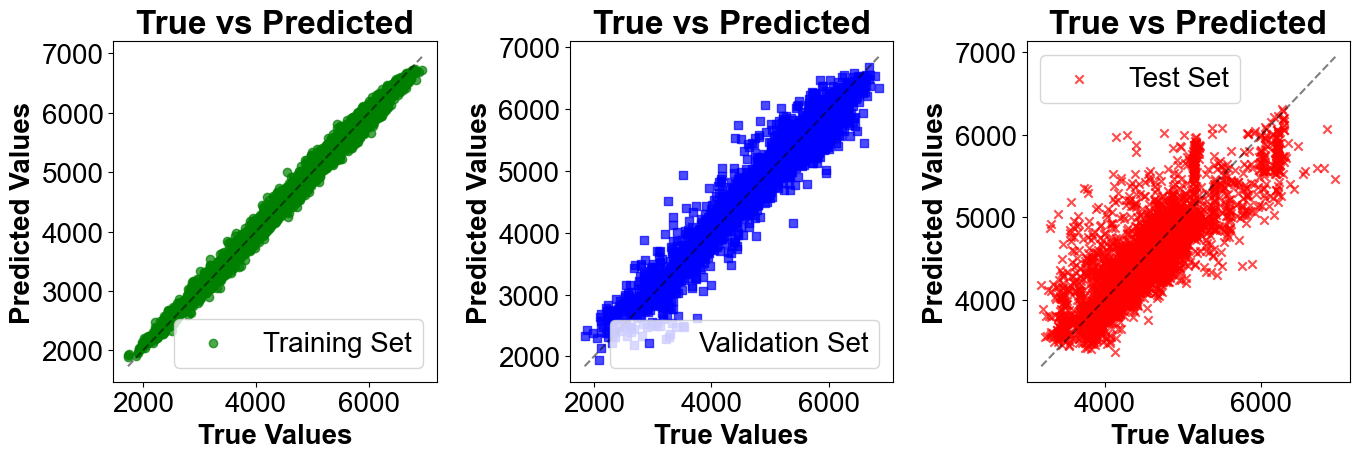

In [71]:
plt.figure(figsize=(14, 5))

ax1 = plt.subplot(1, 3, 1)
plot_true_vs_predicted_v1(ax1, y_train, y_train_pred, 'Training Set', 'o', 'green')

ax2 = plt.subplot(1, 3, 2)
plot_true_vs_predicted_v1(ax2, y_val, y_val_pred, 'Validation Set', 's', 'blue')

ax3 = plt.subplot(1, 3, 3)
plot_true_vs_predicted_v1(ax3, y_test, y_test_pred_vp, 'Test Set', 'x', 'red')

plt.tight_layout()
plt.show()


### 2. Training for Vs

In [72]:
train_df_vs.head()

BOUND_WATER  CALCITE  CHLORITE  DOLOMITE   ILLITE  K-FELDSPAR  KAOLINITE  \
0      0.00139  0.92588       0.0       0.0  0.00081     0.04413    0.01871   
1      0.00291  0.91290       0.0       0.0  0.01286     0.04058    0.01871   
2      0.00468  0.89792       0.0       0.0  0.02690     0.03663    0.01871   
3      0.00407  0.88793       0.0       0.0  0.02208     0.03811    0.01871   
4      0.00134  0.88843       0.0       0.0  0.00042     0.04504    0.01871   

    QUARTZ   UWATER     DEPT    RHOZ  Voigt_Bulk  Reuss_Bulk  Voigt_Shear  \
0  0.00906  0.00001  4361.25  2.8598   73.130039   36.863518    30.716078   
1  0.01203  0.00001  4361.75  2.8542   72.131359   28.036393    30.395018   
2  0.01373  0.00144  4362.25  2.8324   70.923770   21.631896    29.950865   
3  0.01604  0.01306  4362.75  2.7999   70.314500   20.837212    29.748278   
4  0.01929  0.02676  4363.25  2.7698   70.724669   25.762189    29.980905   

   Reuss_Shear      K_VRH      G_VRH           VS  
0     0.071195  54.996778  15.393636  3595.064147  
1     0.034183  50.083876  15.214601  3574.159111  
2     0.016323  46.277833  14.983594  3548.413197  
3     0.005836  45.575856  14.877057  3545.193129  
4     0.003558  48.243429  14.992231  3560.947343

In [73]:
target_column = 'VS'
predictor_cols = ['BOUND_WATER','CALCITE','CHLORITE','DOLOMITE',#'HEMATITE',
                    'ILLITE','K-FELDSPAR','KAOLINITE','QUARTZ','UWATER']

X = train_df_vs[predictor_cols]
y = train_df_vs[target_column]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [74]:
param_grid = {
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [50, 100, 200],
    'subsample': [0.7, 1],
    'colsample_bytree': [0.7, 1],
    'reg_alpha': [ 0.1]
}

xgb_model = XGBRegressor(objective='reg:squarederror')

grid_search = GridSearchCV(estimator=xgb_model, 
                           param_grid=param_grid, 
                           cv=5, 
                           scoring='neg_mean_squared_error', 
                           verbose=1)
grid_search.fit(X_train_scaled, y_train)

print(f"Best parameters found: {grid_search.best_params_}")

best_model = grid_search.best_estimator_

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters found: {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 200, 'reg_alpha': 0.1, 'subsample': 0.7}


In [75]:
filename = 'Model weights/best1_xgb_model.joblib'
joblib.dump(best_model, filename)

['Model weights/best1_xgb_model.joblib']

In [76]:
filename = 'Model weights/best1_xgb_model.joblib'
best_model = joblib.load(filename)

In [77]:
# TEST SET
X_test = test_df_vs.drop(['VS', 'RHOZ', 'VOIGT_VS', 'REUSS_VS', 'VRH_VS', 'DEPT', 
                          'Voigt_Shear', 'Voigt_Bulk', 'Reuss_Shear', 'Reuss_Bulk', 
                          'K_VRH', 'G_VRH'], axis=1)
y_test = test_df_vs['VS']

X_test_scaled = scaler.transform(X_test)

In [78]:
y_val_pred = best_model.predict(X_val_scaled)
y_train_pred = best_model.predict(X_train_scaled)

In [79]:
y_test_pred_vs = best_model.predict(X_test_scaled)

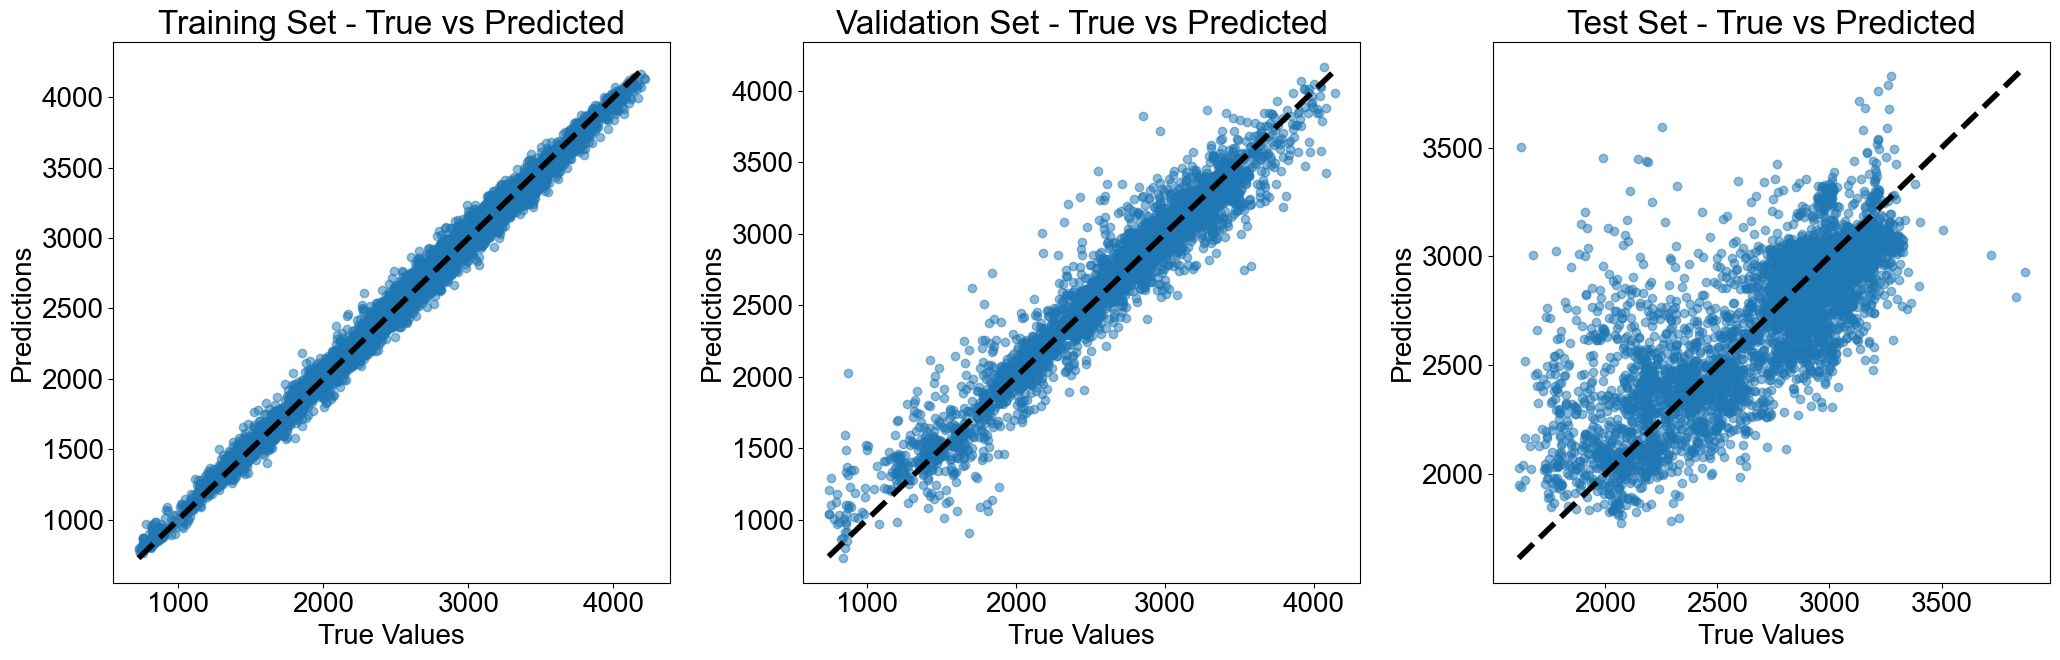

In [80]:
plt.figure(figsize=(21, 7))

# Plot for the training set
ax1 = plt.subplot(1, 3, 1)
plot_true_vs_predicted(ax1, y_train, y_train_pred, 'Training Set - True vs Predicted')

# Plot for the validation set
ax2 = plt.subplot(1, 3, 2)
plot_true_vs_predicted(ax2, y_val, y_val_pred, 'Validation Set - True vs Predicted')

# Plot for the test set
ax3 = plt.subplot(1, 3, 3)
plot_true_vs_predicted(ax3, y_test, y_test_pred_vs, 'Test Set - True vs Predicted')

plt.tight_layout()
plt.show()

In [81]:
# Calculate error metrics for the training set
train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Calculate error metrics for the validation set
val_rmse = mean_squared_error(y_val, y_val_pred, squared=False)
val_mae = mean_absolute_error(y_val, y_val_pred)
val_r2 = r2_score(y_val, y_val_pred)

# Calculate error metrics for the test set
test_rmse = mean_squared_error(y_test, y_test_pred_vs, squared=False)
test_mae = mean_absolute_error(y_test, y_test_pred_vs)
test_r2 = r2_score(y_test, y_test_pred_vs)

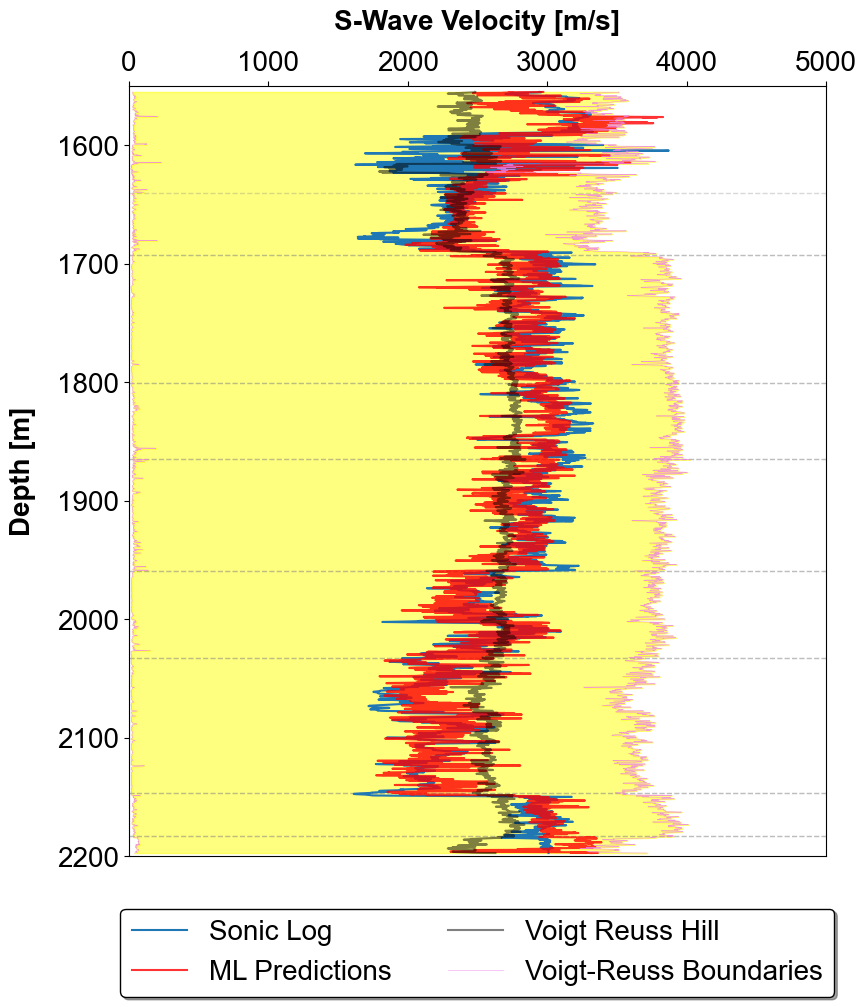

In [82]:
plot_results('S-Wave Velocity [m/s]', test_df_vs, y_test_pred_vs, y_test, 'VOIGT_VS', 'REUSS_VS','VRH_VS', 0, 5000, 2200, 1550)

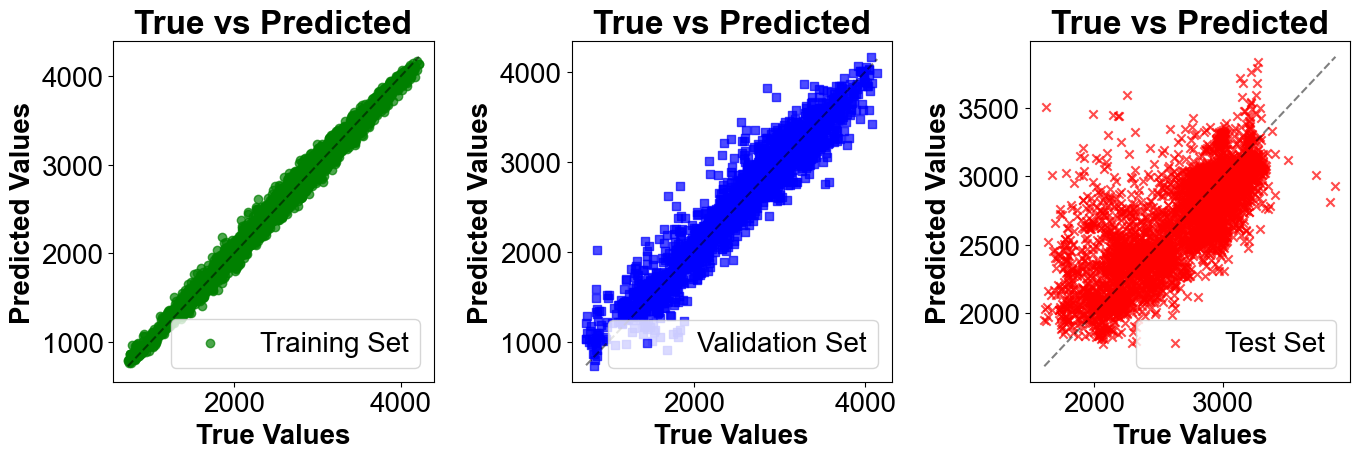

In [83]:
plt.figure(figsize=(14, 5))

ax1 = plt.subplot(1, 3, 1)
plot_true_vs_predicted_v1(ax1, y_train, y_train_pred, 'Training Set', 'o', 'green')

ax2 = plt.subplot(1, 3, 2)
plot_true_vs_predicted_v1(ax2, y_val, y_val_pred, 'Validation Set', 's', 'blue')

ax3 = plt.subplot(1, 3, 3)
plot_true_vs_predicted_v1(ax3, y_test, y_test_pred_vs, 'Test Set', 'x', 'red')

plt.tight_layout()
plt.show()

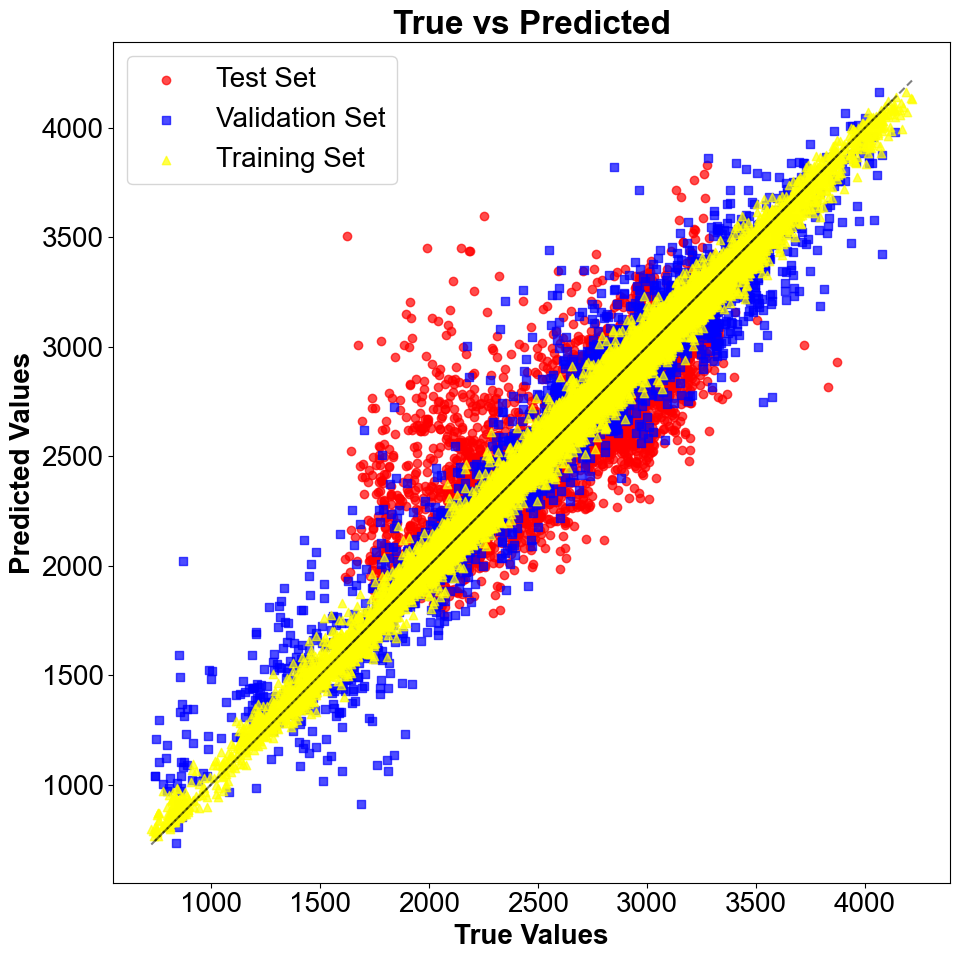

In [84]:
def plot_true_vs_predicted_v1(ax, true_data, predicted_data, label, marker, color):
    ax.scatter(true_data, predicted_data, alpha=0.7, label=label, marker=marker, color=color)
    ax.plot([true_data.min(), true_data.max()], [true_data.min(), true_data.max()], 'k--', alpha=0.5)
    ax.set_xlabel('True Values', fontweight='bold')
    ax.set_ylabel('Predicted Values', fontweight='bold')
    ax.set_title('True vs Predicted', fontweight='bold')
    ax.legend()

plt.figure(figsize=(10, 10))
ax = plt.subplot(1, 1, 1)

plot_true_vs_predicted_v1(ax, y_test, y_test_pred_vs, 'Test Set', 'o', 'red')
plot_true_vs_predicted_v1(ax, y_val, y_val_pred, 'Validation Set', 's', 'blue')
plot_true_vs_predicted_v1(ax, y_train, y_train_pred, 'Training Set', '^', 'yellow')

plt.tight_layout()
plt.show()

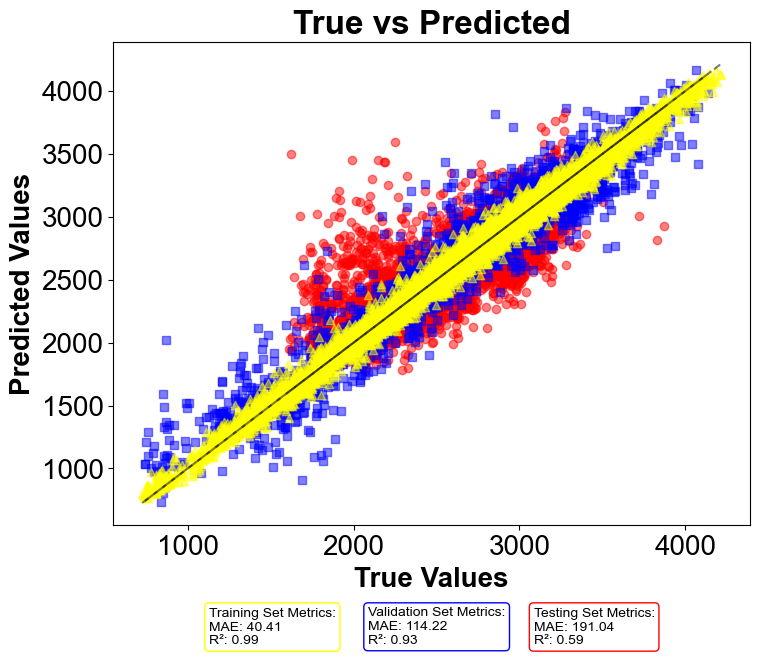

In [85]:
def plot_true_vs_predicted_v2(ax, true_data, predicted_data, label, marker, color, x_pos, y_pos):
    mae = mean_absolute_error(true_data, predicted_data)
    r2 = r2_score(true_data, predicted_data)
    ax.scatter(true_data, predicted_data, alpha=0.5, label=f'{label}', color=color, marker=marker)
    ax.plot([true_data.min(), true_data.max()], [true_data.min(), true_data.max()], 'k--', alpha=0.5)
    ax.set_xlabel('True Values', fontweight='bold')
    ax.set_ylabel('Predicted Values', fontweight='bold')
    ax.set_title('True vs Predicted', fontweight='bold')
    # Set text for metrics below the plot area
    ax.text(x_pos, y_pos, f'{label} Metrics:\nMAE: {mae:.2f}\nR²: {r2:.2f}', transform=ax.transAxes, verticalalignment='top', horizontalalignment='left', fontsize=10, bbox=dict(boxstyle="round,pad=0.3", edgecolor=color, facecolor='white'))

plt.figure(figsize=(8, 8))
ax = plt.subplot(1, 1, 1)

# Adjust x_pos and y_pos for each dataset to display metrics in one horizontal line below the graph
plot_true_vs_predicted_v2(ax, y_test, y_test_pred_vs, 'Testing Set', 'o', 'red', 0.66, -0.17)
plot_true_vs_predicted_v2(ax, y_val, y_val_pred, 'Validation Set', 's', 'blue', 0.4, -0.17)
plot_true_vs_predicted_v2(ax, y_train, y_train_pred, 'Training Set', '^', 'yellow', 0.15, -0.17)

plt.tight_layout(rect=[0, 0.1, 1, 1])
plt.show()

## Calculating K and G from predicted Vp and Vs

In [86]:
test_df_vp.head()

BOUND_WATER  CALCITE  CHLORITE  DOLOMITE  ILLITE  K-FELDSPAR  KAOLINITE  \
0      0.00026  0.08100       0.0   0.47844     0.0     0.23040    0.00381   
1      0.00008  0.06900       0.0   0.47355     0.0     0.23773    0.00114   
2      0.00003  0.04209       0.0   0.48604     0.0     0.24202    0.00041   
3      0.00036  0.05095       0.0   0.43499     0.0     0.25269    0.00529   
4      0.00088  0.08433       0.0   0.29721     0.0     0.27180    0.01301   

    QUARTZ   UWATER       DEPT  ...  Voigt_Bulk  Reuss_Bulk  Voigt_Shear  \
0  0.10848  0.05685  1554.7848  ...   64.409873   22.898393    32.356260   
1  0.11768  0.05759  1554.9372  ...   63.636714   23.594883    32.263222   
2  0.12550  0.05397  1555.0896  ...   63.196373   24.792859    32.371559   
3  0.15076  0.04891  1555.2420  ...   60.363835   23.819622    31.636151   
4  0.23370  0.03773  1555.3944  ...   53.625630   22.718279    30.451028   

   Reuss_Shear      K_VRH      G_VRH           VP     VOIGT_VP     REUSS_VP  \
0     0.001751  43.654133  16.179005  5699.424897  6403.244580  2954.720357   
1     0.001734  43.615799  16.132478  5612.334615  6384.419770  3003.048539   
2     0.001852  43.994616  16.186706  5580.766861  6367.070757  3074.245872   
3     0.002029  42.091729  15.819090  5496.963955  6265.390794  3019.828207   
4     0.002590  38.171954  15.226809  5337.044517  6033.921752  2963.007179   

        VRH_VP  
0  4986.577661  
1  4988.943592  
2  4999.528863  
3  4918.052674  
4  4753.294818  

[5 rows x 21 columns]

In [87]:
test_df_vp.head()

BOUND_WATER  CALCITE  CHLORITE  DOLOMITE  ILLITE  K-FELDSPAR  KAOLINITE  \
0      0.00026  0.08100       0.0   0.47844     0.0     0.23040    0.00381   
1      0.00008  0.06900       0.0   0.47355     0.0     0.23773    0.00114   
2      0.00003  0.04209       0.0   0.48604     0.0     0.24202    0.00041   
3      0.00036  0.05095       0.0   0.43499     0.0     0.25269    0.00529   
4      0.00088  0.08433       0.0   0.29721     0.0     0.27180    0.01301   

    QUARTZ   UWATER       DEPT  ...  Voigt_Bulk  Reuss_Bulk  Voigt_Shear  \
0  0.10848  0.05685  1554.7848  ...   64.409873   22.898393    32.356260   
1  0.11768  0.05759  1554.9372  ...   63.636714   23.594883    32.263222   
2  0.12550  0.05397  1555.0896  ...   63.196373   24.792859    32.371559   
3  0.15076  0.04891  1555.2420  ...   60.363835   23.819622    31.636151   
4  0.23370  0.03773  1555.3944  ...   53.625630   22.718279    30.451028   

   Reuss_Shear      K_VRH      G_VRH           VP     VOIGT_VP     REUSS_VP  \
0     0.001751  43.654133  16.179005  5699.424897  6403.244580  2954.720357   
1     0.001734  43.615799  16.132478  5612.334615  6384.419770  3003.048539   
2     0.001852  43.994616  16.186706  5580.766861  6367.070757  3074.245872   
3     0.002029  42.091729  15.819090  5496.963955  6265.390794  3019.828207   
4     0.002590  38.171954  15.226809  5337.044517  6033.921752  2963.007179   

        VRH_VP  
0  4986.577661  
1  4988.943592  
2  4999.528863  
3  4918.052674  
4  4753.294818  

[5 rows x 21 columns]

In [88]:
len(y_test_pred_vp)

4217

In [89]:
data = {
    'DEPT': test_df_vp['DEPT'],
    'y_test_pred_vs': y_test_pred_vs,
    'y_test_pred_vp': y_test_pred_vp,
    'RHOZ': test_df_vp['RHOZ'],
    'Voigt_Bulk': test_df_vp['Voigt_Bulk'],
    'Reuss_Bulk': test_df_vp['Reuss_Bulk'],
    'Voigt_Shear': test_df_vp['Voigt_Shear'],
    'Reuss_Shear': test_df_vp['Reuss_Shear'],
    'K_VRH': test_df_vp['K_VRH'],
    'G_VRH': test_df_vp['G_VRH'],
    'VP': test_df_vp['VP'],
    'VS': test_df_vs['VS'],
}

df_kg = pd.DataFrame(data)

df_kg['G_pred'] = ((df_kg['RHOZ']*1000) * df_kg['y_test_pred_vs']**2)/ 1e9
df_kg['K_pred'] = ((df_kg['RHOZ']*1000) * (df_kg['y_test_pred_vp']**2 - (4/3) * df_kg['y_test_pred_vs']**2))/ 1e9

df_kg['G'] = ((df_kg['RHOZ']*1000) * df_kg['VS']**2)/ 1e9
df_kg['K'] = ((df_kg['RHOZ']*1000) * (df_kg['VP']**2 - (4/3) * df_kg['VS']**2))/ 1e9

In [90]:
df_kg.head()

DEPT  y_test_pred_vs  y_test_pred_vp     RHOZ  Voigt_Bulk  Reuss_Bulk  \
0  1554.7848     2971.642090     5427.310547  2.62311   64.409873   22.898393   
1  1554.9372     2943.712402     5444.166504  2.61659   63.636714   23.594883   
2  1555.0896     2722.279053     5284.386719  2.62357   63.196373   24.792859   
3  1555.2420     2753.941162     5315.319824  2.61228   60.363835   23.819622   
4  1555.3944     2684.152832     5278.909180  2.58807   53.625630   22.718279   

   Voigt_Shear  Reuss_Shear      K_VRH      G_VRH           VP           VS  \
0    32.356260     0.001751  43.654133  16.179005  5699.424897  2946.238968   
1    32.263222     0.001734  43.615799  16.132478  5612.334615  2959.233644   
2    32.371559     0.001852  43.994616  16.186706  5580.766861  2954.210608   
3    31.636151     0.002029  42.091729  15.819090  5496.963955  2923.682674   
4    30.451028     0.002590  38.171954  15.226809  5337.044517  2865.826839   

      G_pred     K_pred          G          K  
0  23.163785  46.380493  22.769445  54.848387  
1  22.673911  47.321093  22.913645  51.866609  
2  19.442760  47.338837  22.896841  51.181859  
3  19.812033  47.387721  22.329561  49.161505  
4  18.646207  47.259830  21.255724  45.377734

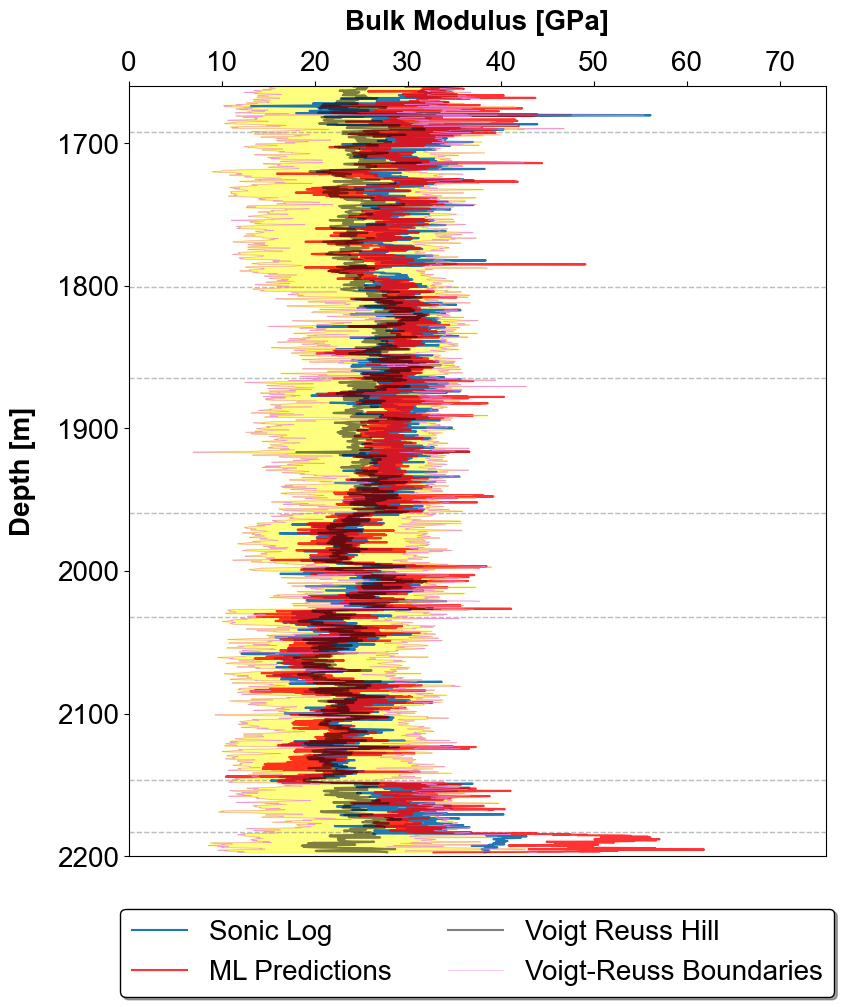

In [91]:
plot_results('Bulk Modulus [GPa]', df_kg, df_kg['K_pred'], df_kg['K'], 'Voigt_Bulk', 'Reuss_Bulk','K_VRH', 0, 75, 2200, 1660, 'yellow')

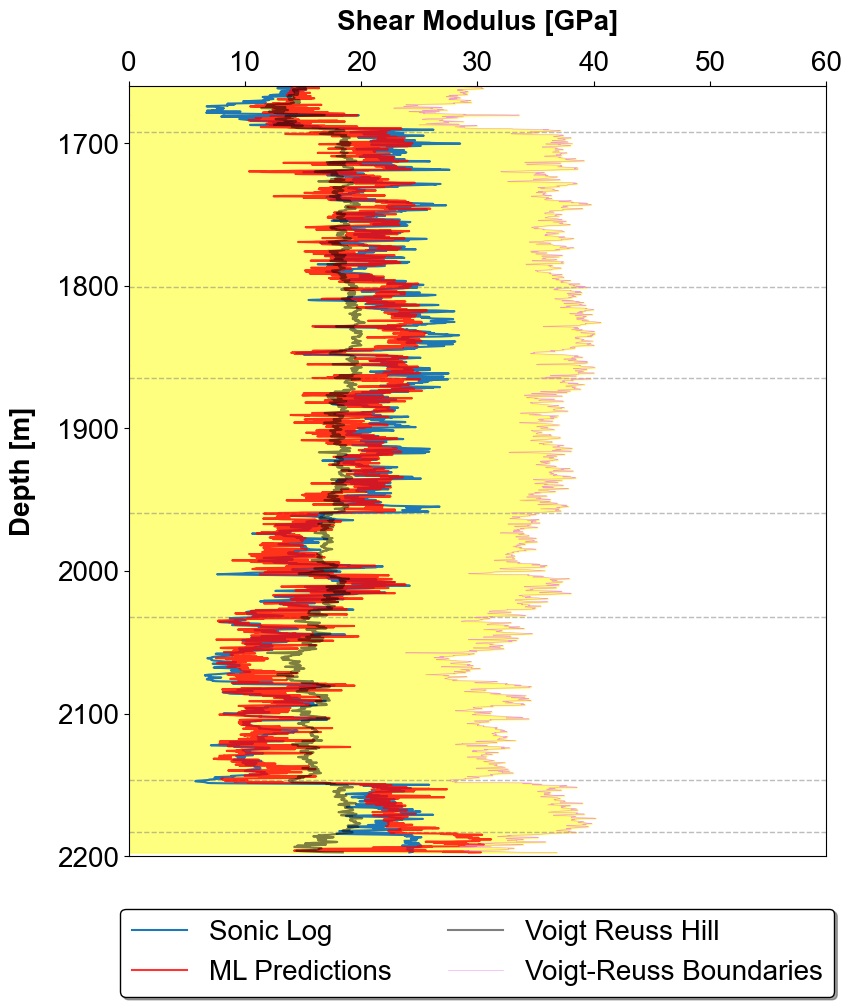

In [92]:
plot_results('Shear Modulus [GPa]', df_kg, df_kg['G_pred'], df_kg['G'], 'Voigt_Shear', 'Reuss_Shear','G_VRH', 0, 60, 2200, 1660, 'yellow')

In [93]:
# Checking our Results
df.head()

BOUND_WATER  CALCITE  CHLORITE  DOLOMITE   ILLITE  K-FELDSPAR  KAOLINITE  \
0      0.00139  0.92588       0.0       0.0  0.00081     0.04413    0.01871   
1      0.00291  0.91290       0.0       0.0  0.01286     0.04058    0.01871   
2      0.00468  0.89792       0.0       0.0  0.02690     0.03663    0.01871   
3      0.00407  0.88793       0.0       0.0  0.02208     0.03811    0.01871   
4      0.00134  0.88843       0.0       0.0  0.00042     0.04504    0.01871   

    QUARTZ   UWATER     DEPT    RHOZ  Voigt_Bulk  Reuss_Bulk  Voigt_Shear  \
0  0.00906  0.00001  4361.25  2.8598   73.130039   36.863518    30.716078   
1  0.01203  0.00001  4361.75  2.8542   72.131359   28.036393    30.395018   
2  0.01373  0.00144  4362.25  2.8324   70.923770   21.631896    29.950865   
3  0.01604  0.01306  4362.75  2.7999   70.314500   20.837212    29.748278   
4  0.01929  0.02676  4363.25  2.7698   70.724669   25.762189    29.980905   

   Reuss_Shear      K_VRH      G_VRH           VP           VS       VRH_VP  
0     0.071195  54.996778  15.393636  6263.510060  3595.064147  5138.872438  
1     0.034183  50.083876  15.214601  6481.686259  3574.159111  4965.369890  
2     0.016323  46.277833  14.983594  6563.708892  3548.413197  4836.544372  
3     0.005836  45.575856  14.877057  6334.250151  3545.193129  4833.449955  
4     0.003558  48.243429  14.992231  6141.289554  3560.947343  4963.331164

In [94]:
print(test_df_vp[test_df_vp['DEPT']>1800].iloc[0])

BOUND_WATER       0.000970
CALCITE           0.000000
CHLORITE          0.000000
DOLOMITE          0.000000
ILLITE            0.005300
K-FELDSPAR        0.010910
KAOLINITE         0.004670
QUARTZ            0.875500
UWATER            0.059540
DEPT           1800.148800
RHOZ              2.518250
Voigt_Bulk       32.950702
Reuss_Bulk       17.210428
Voigt_Shear      38.699614
Reuss_Shear       0.001653
K_VRH            25.080565
G_VRH            19.350633
VP             5006.460107
VOIGT_VP       5794.391911
REUSS_VP       2614.413108
VRH_VP         4495.004645
Name: 1610, dtype: float64


## Double Checking our model on VW2 Data

### 1. V-Wave Velocity

In [95]:
filename = 'Model weights/best_xgb_model.joblib'
best_model = joblib.load(filename)

In [96]:
X_test = test_df2_vp.drop(['VP', 'RHOZ', 'VOIGT_VP', 'REUSS_VP', 'VRH_VP', 'DEPT', 
                          'Voigt_Shear', 'Voigt_Bulk', 'Reuss_Shear', 'Reuss_Bulk', 
                          'K_VRH', 'G_VRH'], axis=1)
y_test = test_df2_vp['VP']
X_test_scaled = scaler.transform(X_test)

In [97]:
X_test.columns

Index(['BOUND_WATER', 'CALCITE', 'CHLORITE', 'DOLOMITE', 'ILLITE',
       'K-FELDSPAR', 'KAOLINITE', 'QUARTZ', 'UWATER'],
      dtype='object')

In [98]:
# PREDICTIONS
y_test_pred_vp = best_model.predict(X_test_scaled)

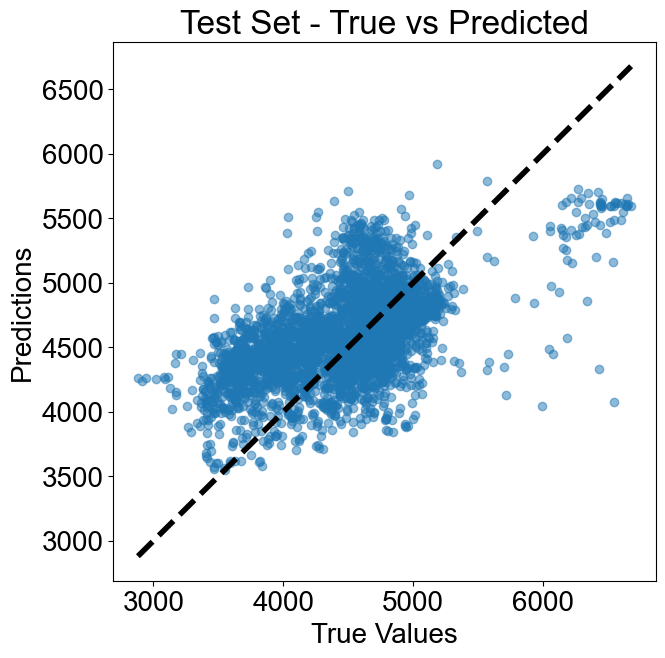

In [99]:
plt.figure(figsize=(7, 7))
plt.scatter(y_test, y_test_pred_vp, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.title('Test Set - True vs Predicted')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()

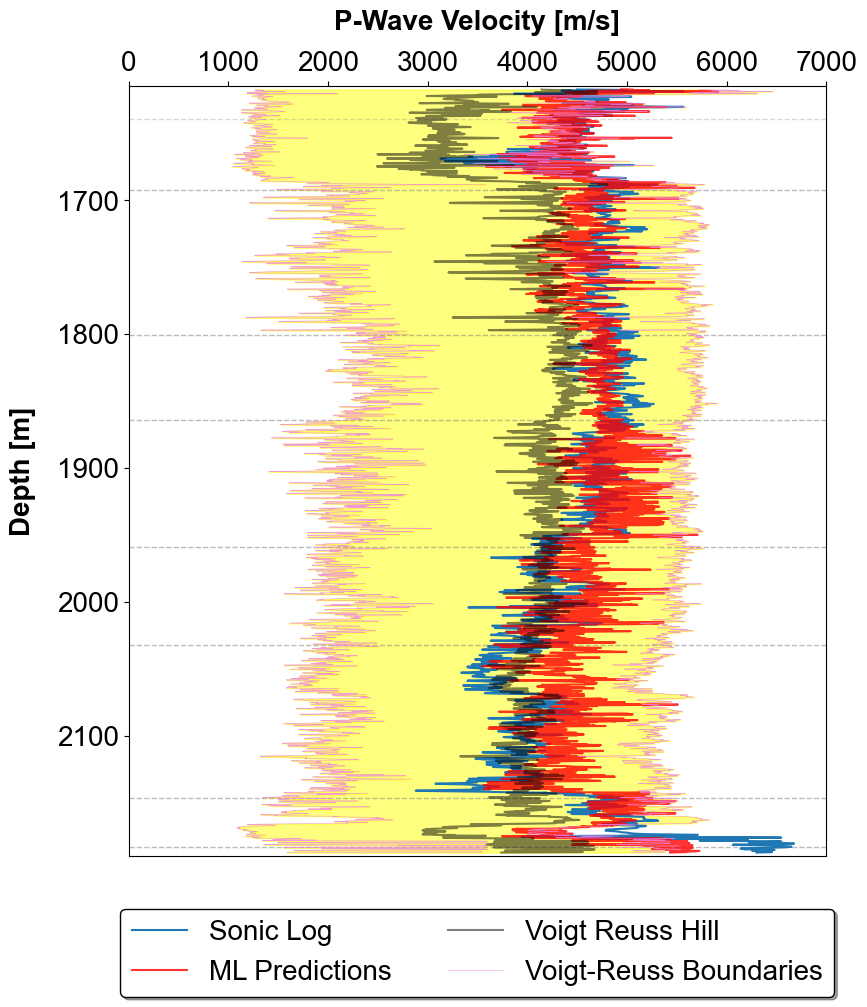

In [100]:
plot_results('P-Wave Velocity [m/s]', test_df2_vp, y_test_pred_vp, y_test, 'VOIGT_VP', 'REUSS_VP','VRH_VP', 0, 7000, 2190, 1615)

### 2. S-Wave Velocity

In [101]:
filename = 'Model weights/best1_xgb_model.joblib'
best_model = joblib.load(filename)

In [102]:
X_test = test_df2_vs.drop(['VS', 'RHOZ', 'VOIGT_VS', 'REUSS_VS', 'VRH_VS', 'DEPT', 
                          'Voigt_Shear', 'Voigt_Bulk', 'Reuss_Shear', 'Reuss_Bulk', 
                          'K_VRH', 'G_VRH'], axis=1)
y_test = test_df2_vs['VS']

X_test_scaled = scaler.transform(X_test)

In [103]:
y_test_pred_vs = best_model.predict(X_test_scaled)

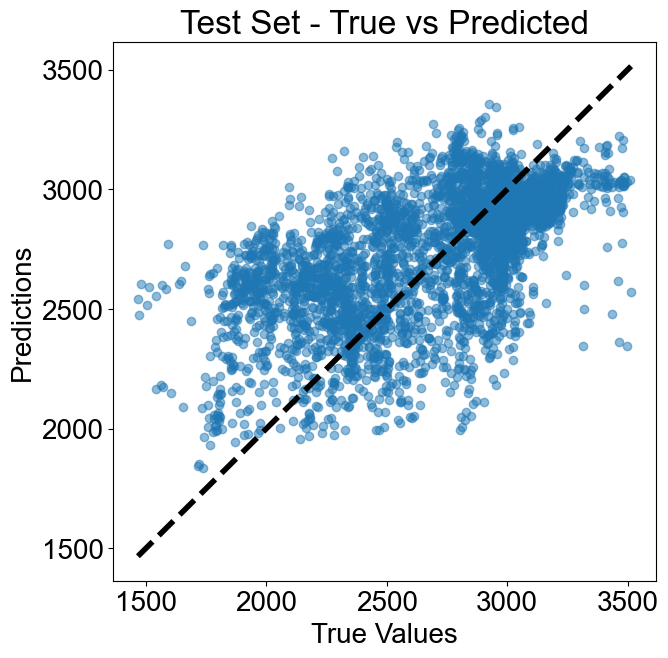

In [104]:
plt.figure(figsize=(7, 7))
plt.scatter(y_test, y_test_pred_vs, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.title('Test Set - True vs Predicted')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()

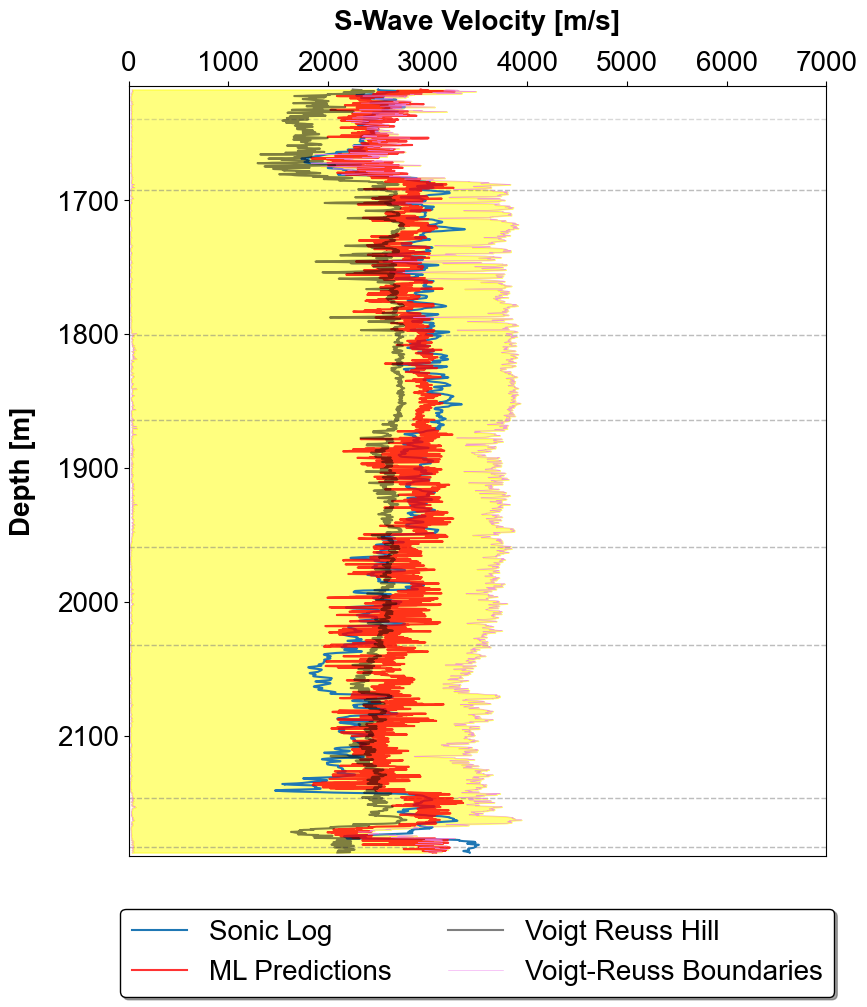

In [105]:
plot_results('S-Wave Velocity [m/s]', test_df2_vs, y_test_pred_vs, y_test, 'VOIGT_VS', 'REUSS_VS','VRH_VS', 0, 7000, 2190, 1615)

In [106]:
data = {
    'DEPT': test_df2_vp['DEPT'],
    'y_test_pred_vs': y_test_pred_vs,
    'y_test_pred_vp': y_test_pred_vp,
    'RHOZ': test_df2_vp['RHOZ'],
    'Voigt_Bulk': test_df2_vp['Voigt_Bulk'],
    'Reuss_Bulk': test_df2_vp['Reuss_Bulk'],
    'Voigt_Shear': test_df2_vp['Voigt_Shear'],
    'Reuss_Shear': test_df2_vp['Reuss_Shear'],
    'K_VRH': test_df2_vp['K_VRH'],
    'G_VRH': test_df2_vp['G_VRH'],
    'VP': test_df2_vp['VP'],
    'VS': test_df2_vs['VS'],
}

df_kg = pd.DataFrame(data)

df_kg['G_pred'] = ((df_kg['RHOZ']*1000) * df_kg['y_test_pred_vs']**2)/ 1e9
df_kg['K_pred'] = ((df_kg['RHOZ']*1000) * (df_kg['y_test_pred_vp']**2 - (4/3) * df_kg['y_test_pred_vs']**2))/ 1e9

df_kg['G'] = ((df_kg['RHOZ']*1000) * df_kg['VS']**2)/ 1e9
df_kg['K'] = ((df_kg['RHOZ']*1000) * (df_kg['VP']**2 - (4/3) * df_kg['VS']**2))/ 1e9

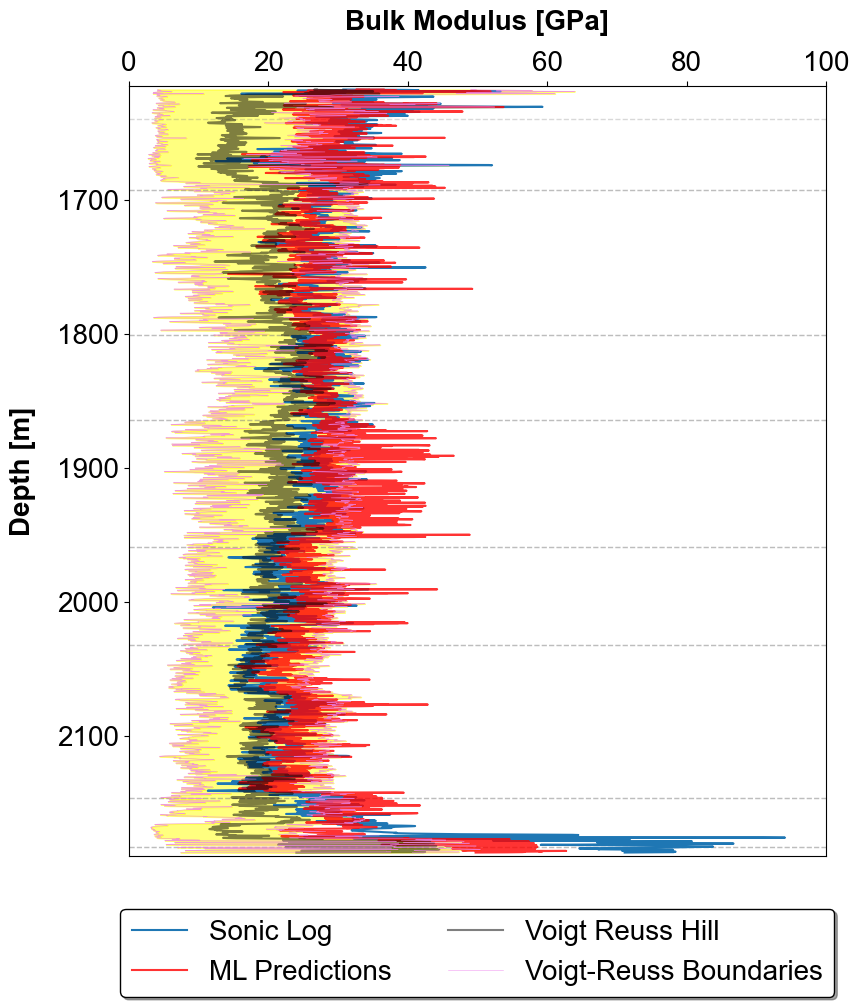

In [107]:
plot_results('Bulk Modulus [GPa]', df_kg, df_kg['K_pred'], df_kg['K'], 'Voigt_Bulk', 'Reuss_Bulk','K_VRH', 0, 100, 2190, 1615, 'yellow')

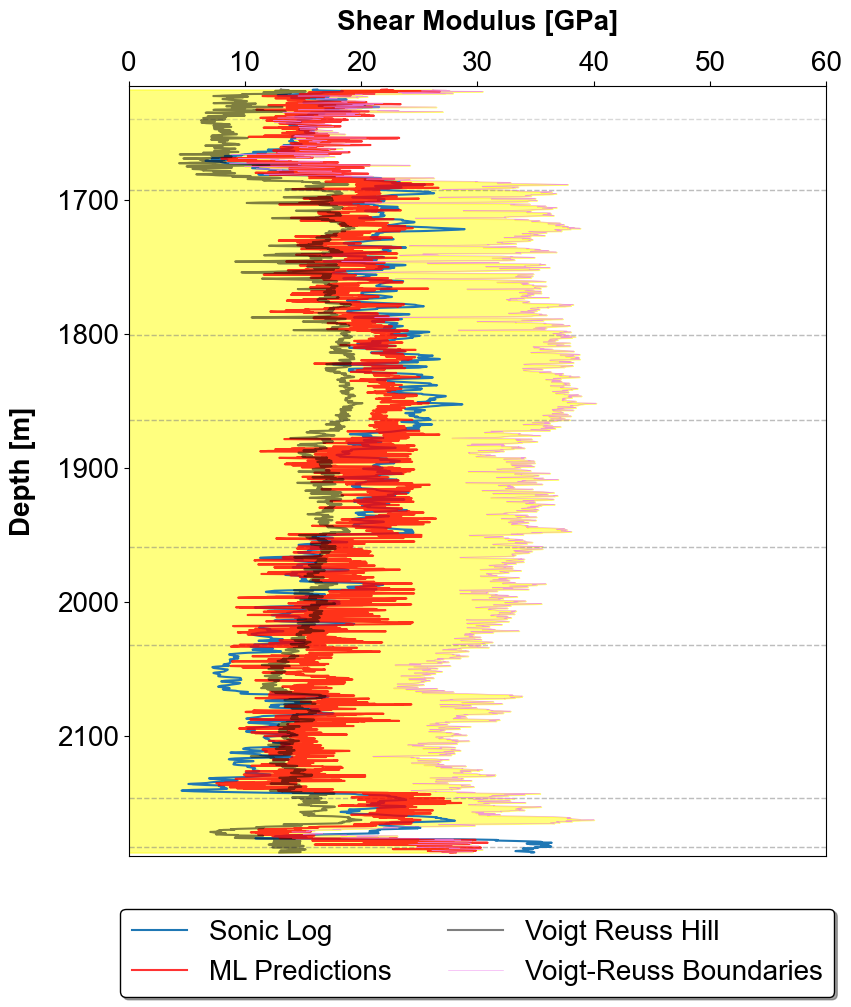

In [108]:
plot_results('Shear Modulus [GPa]', df_kg, df_kg['G_pred'], df_kg['G'], 'Voigt_Shear', 'Reuss_Shear','G_VRH', 0, 60, 2190, 1615, 'yellow')